In [1]:
import sys; sys.path.insert(0, '..') # if you don't find it here, look one above
import matplotlib.pyplot as plt
import datajoint as dj
import numpy as np
import seaborn as sns
import pandas as pd
from datetime import datetime
from pathlib import Path

from create_trials_df import create_trials_df_from_dj
from create_days_df import create_days_df_from_dj, lazy_load_days_summary_df

from plot_trials_info import *
from plot_days_info import *

import plot_utils as pu
import dj_utils as dju

from multiplot_summaries import *
# settings
%load_ext autoreload
%autoreload 2

dj.blob.use_32bit_dims = True # necessary for pd.blob read
sns.set_context("talk")


[2023-07-25 16:48:42,371][INFO]: Connecting jbreda@bdata00.pni.princeton.edu:3306
[2023-07-25 16:48:42,818][INFO]: Connected jbreda@bdata00.pni.princeton.edu:3306


In [34]:
# ANIMAL_IDS = ["R511", "R512", "R513"]
ANIMAL_IDS = ["R013", "R014", "R015"]
# date_min, date_max = return_date_window(latest_date=None, n_days_back=20)
# flex_date_min = (datetime.today() - timedelta(days=4)).strftime("%Y-%m-%d")

In [35]:
df = create_trials_df_from_dj(ANIMAL_IDS, date_min="2023-07-25")
# trials_df = create_trials_df_from_dj(["R610"], date_min="2023-07-24")

fetched 1 sessions for R013 between 2023-07-25 and 2023-07-25
fetched 1 sessions for R014 between 2023-07-25 and 2023-07-25
fetched 1 sessions for R015 between 2023-07-25 and 2023-07-25


In [15]:
np.sum(df.cpoke_dur)


0.0

In [26]:
df.n_settling_ins.nunique()

1

<Axes: xlabel='n_settling_ins', ylabel='Count'>

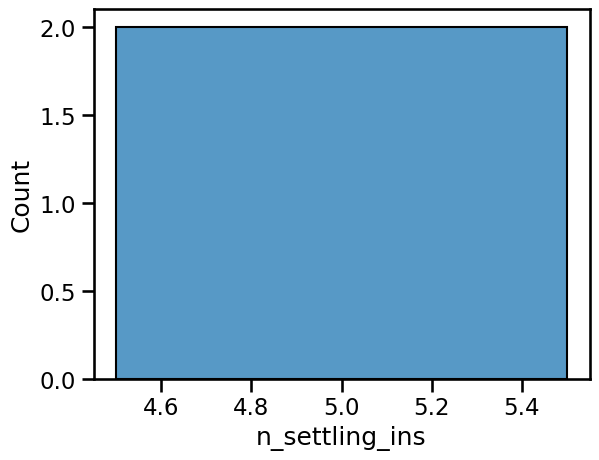

In [25]:
sns.histplot(df.n_settling_ins, binwidth=None)

making R013_2023-07-25_day_summary


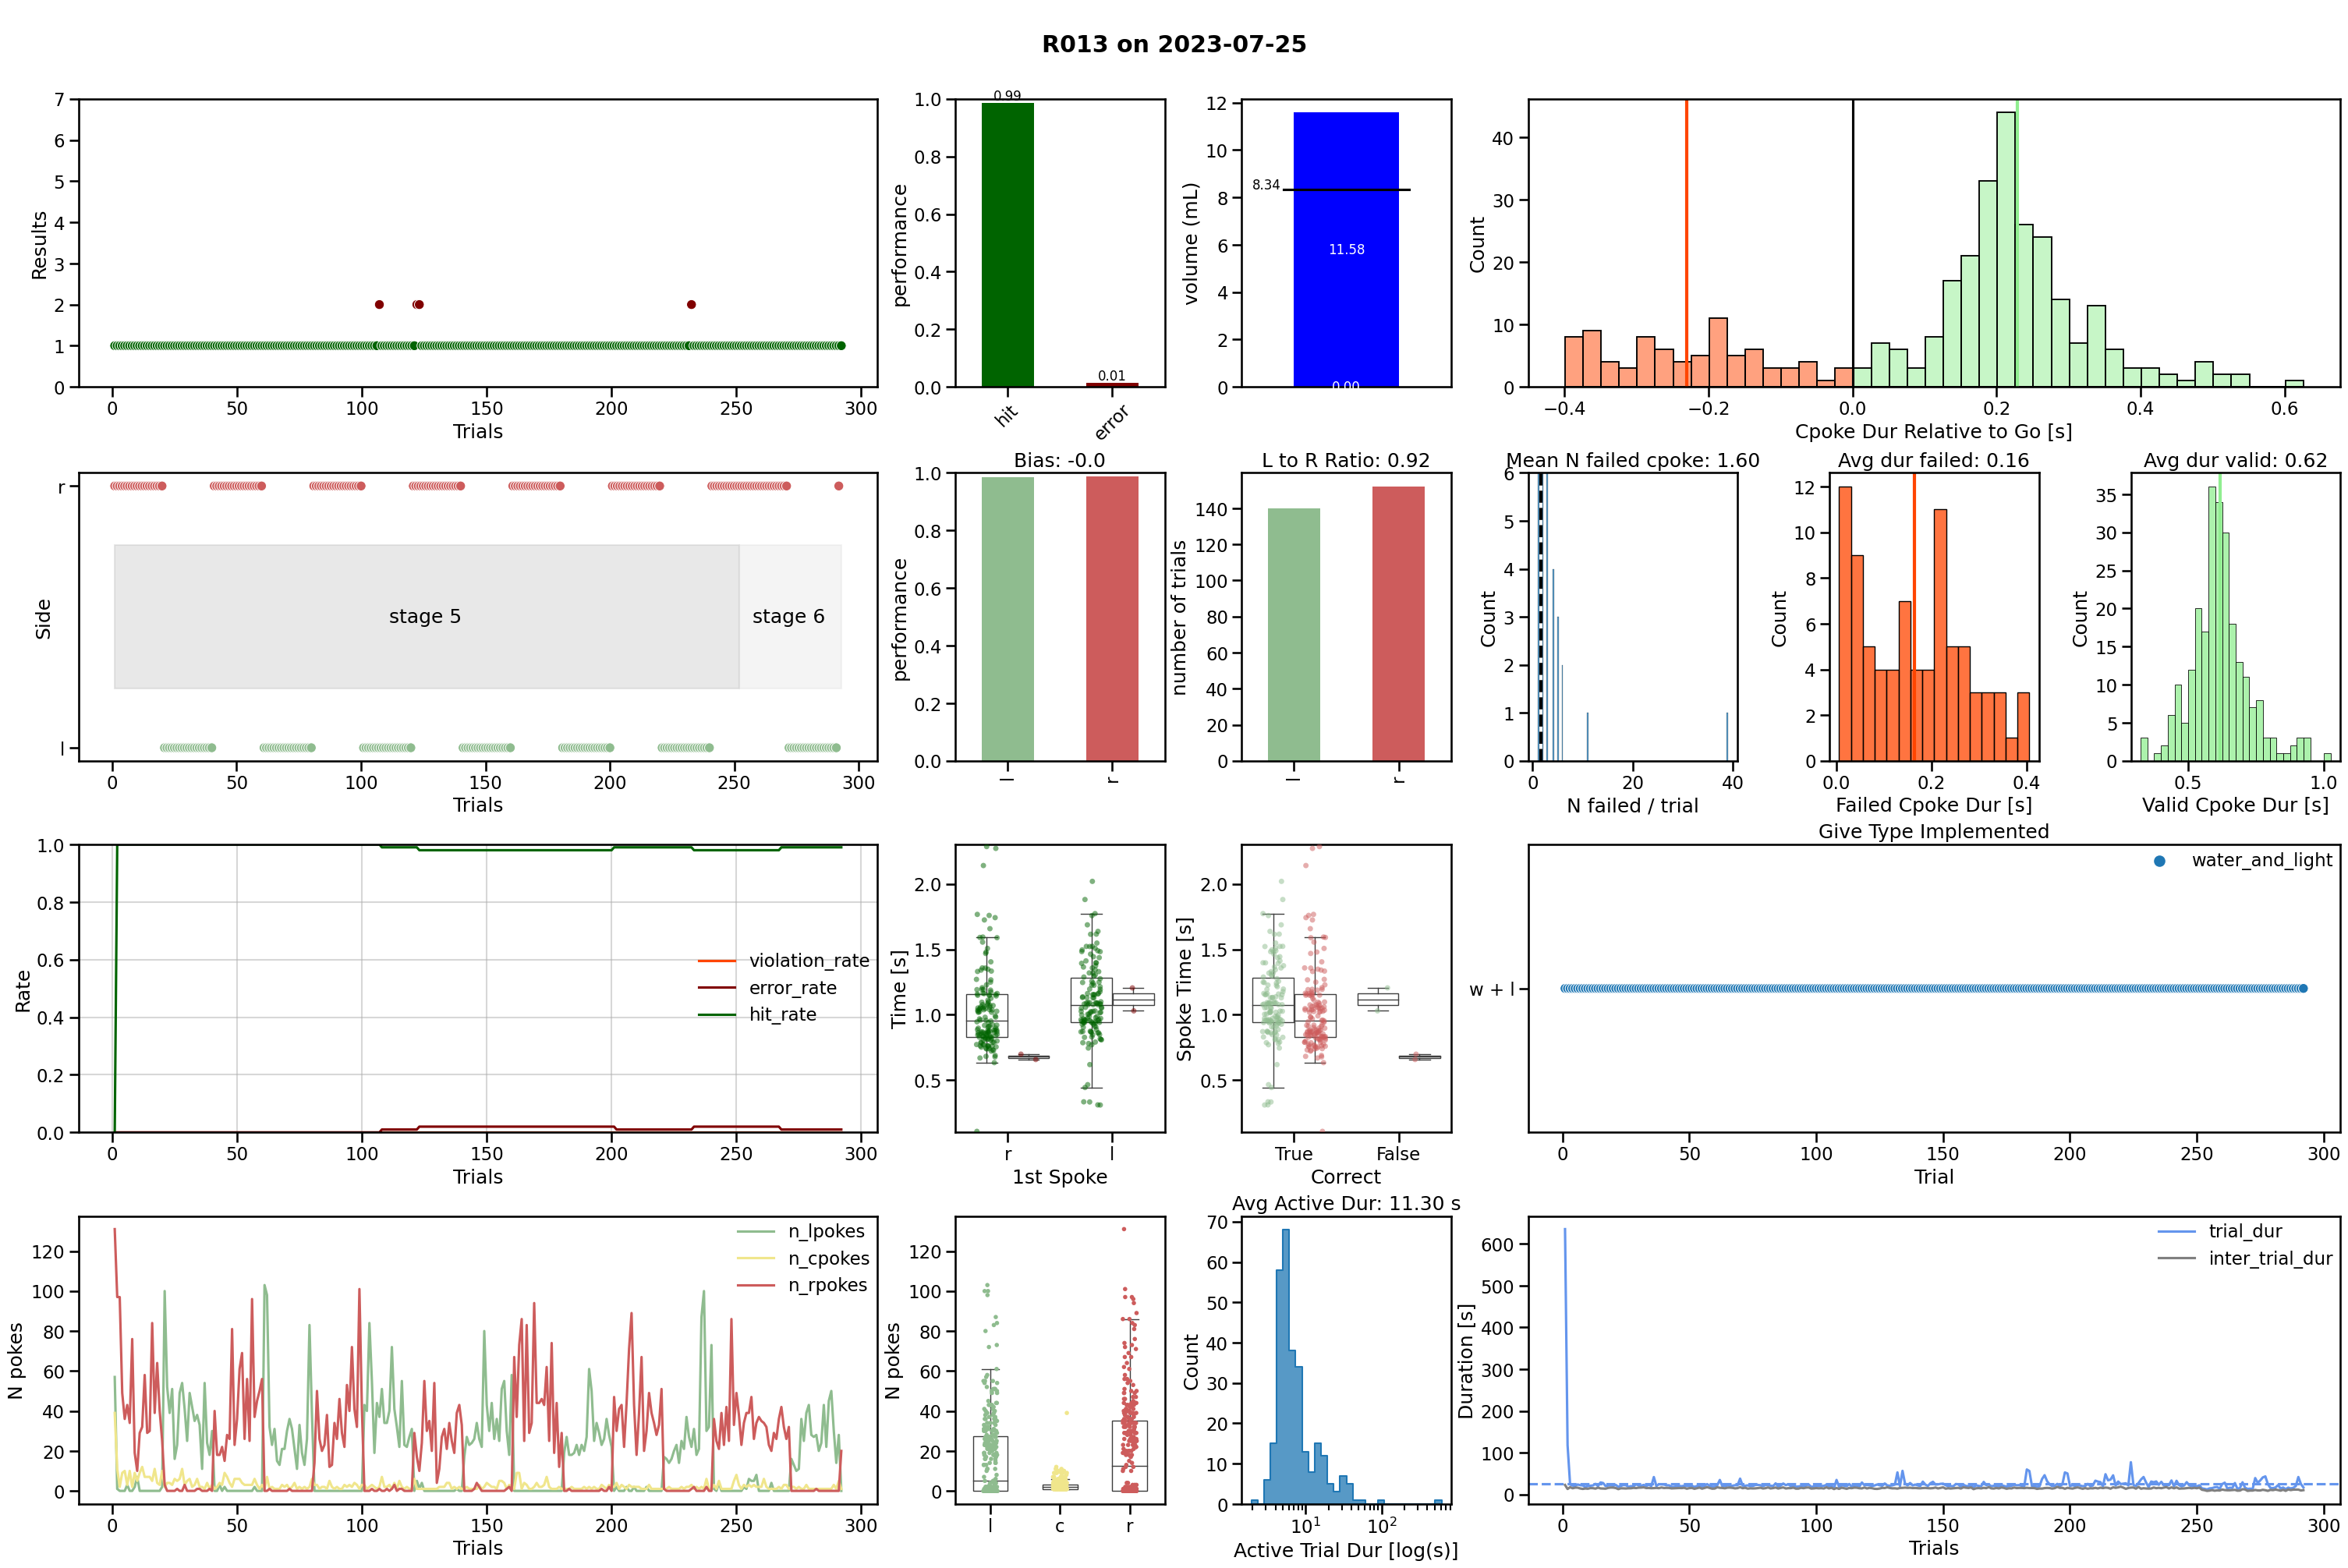

making R014_2023-07-25_day_summary
No valid cpokes, make sure fixation is on!


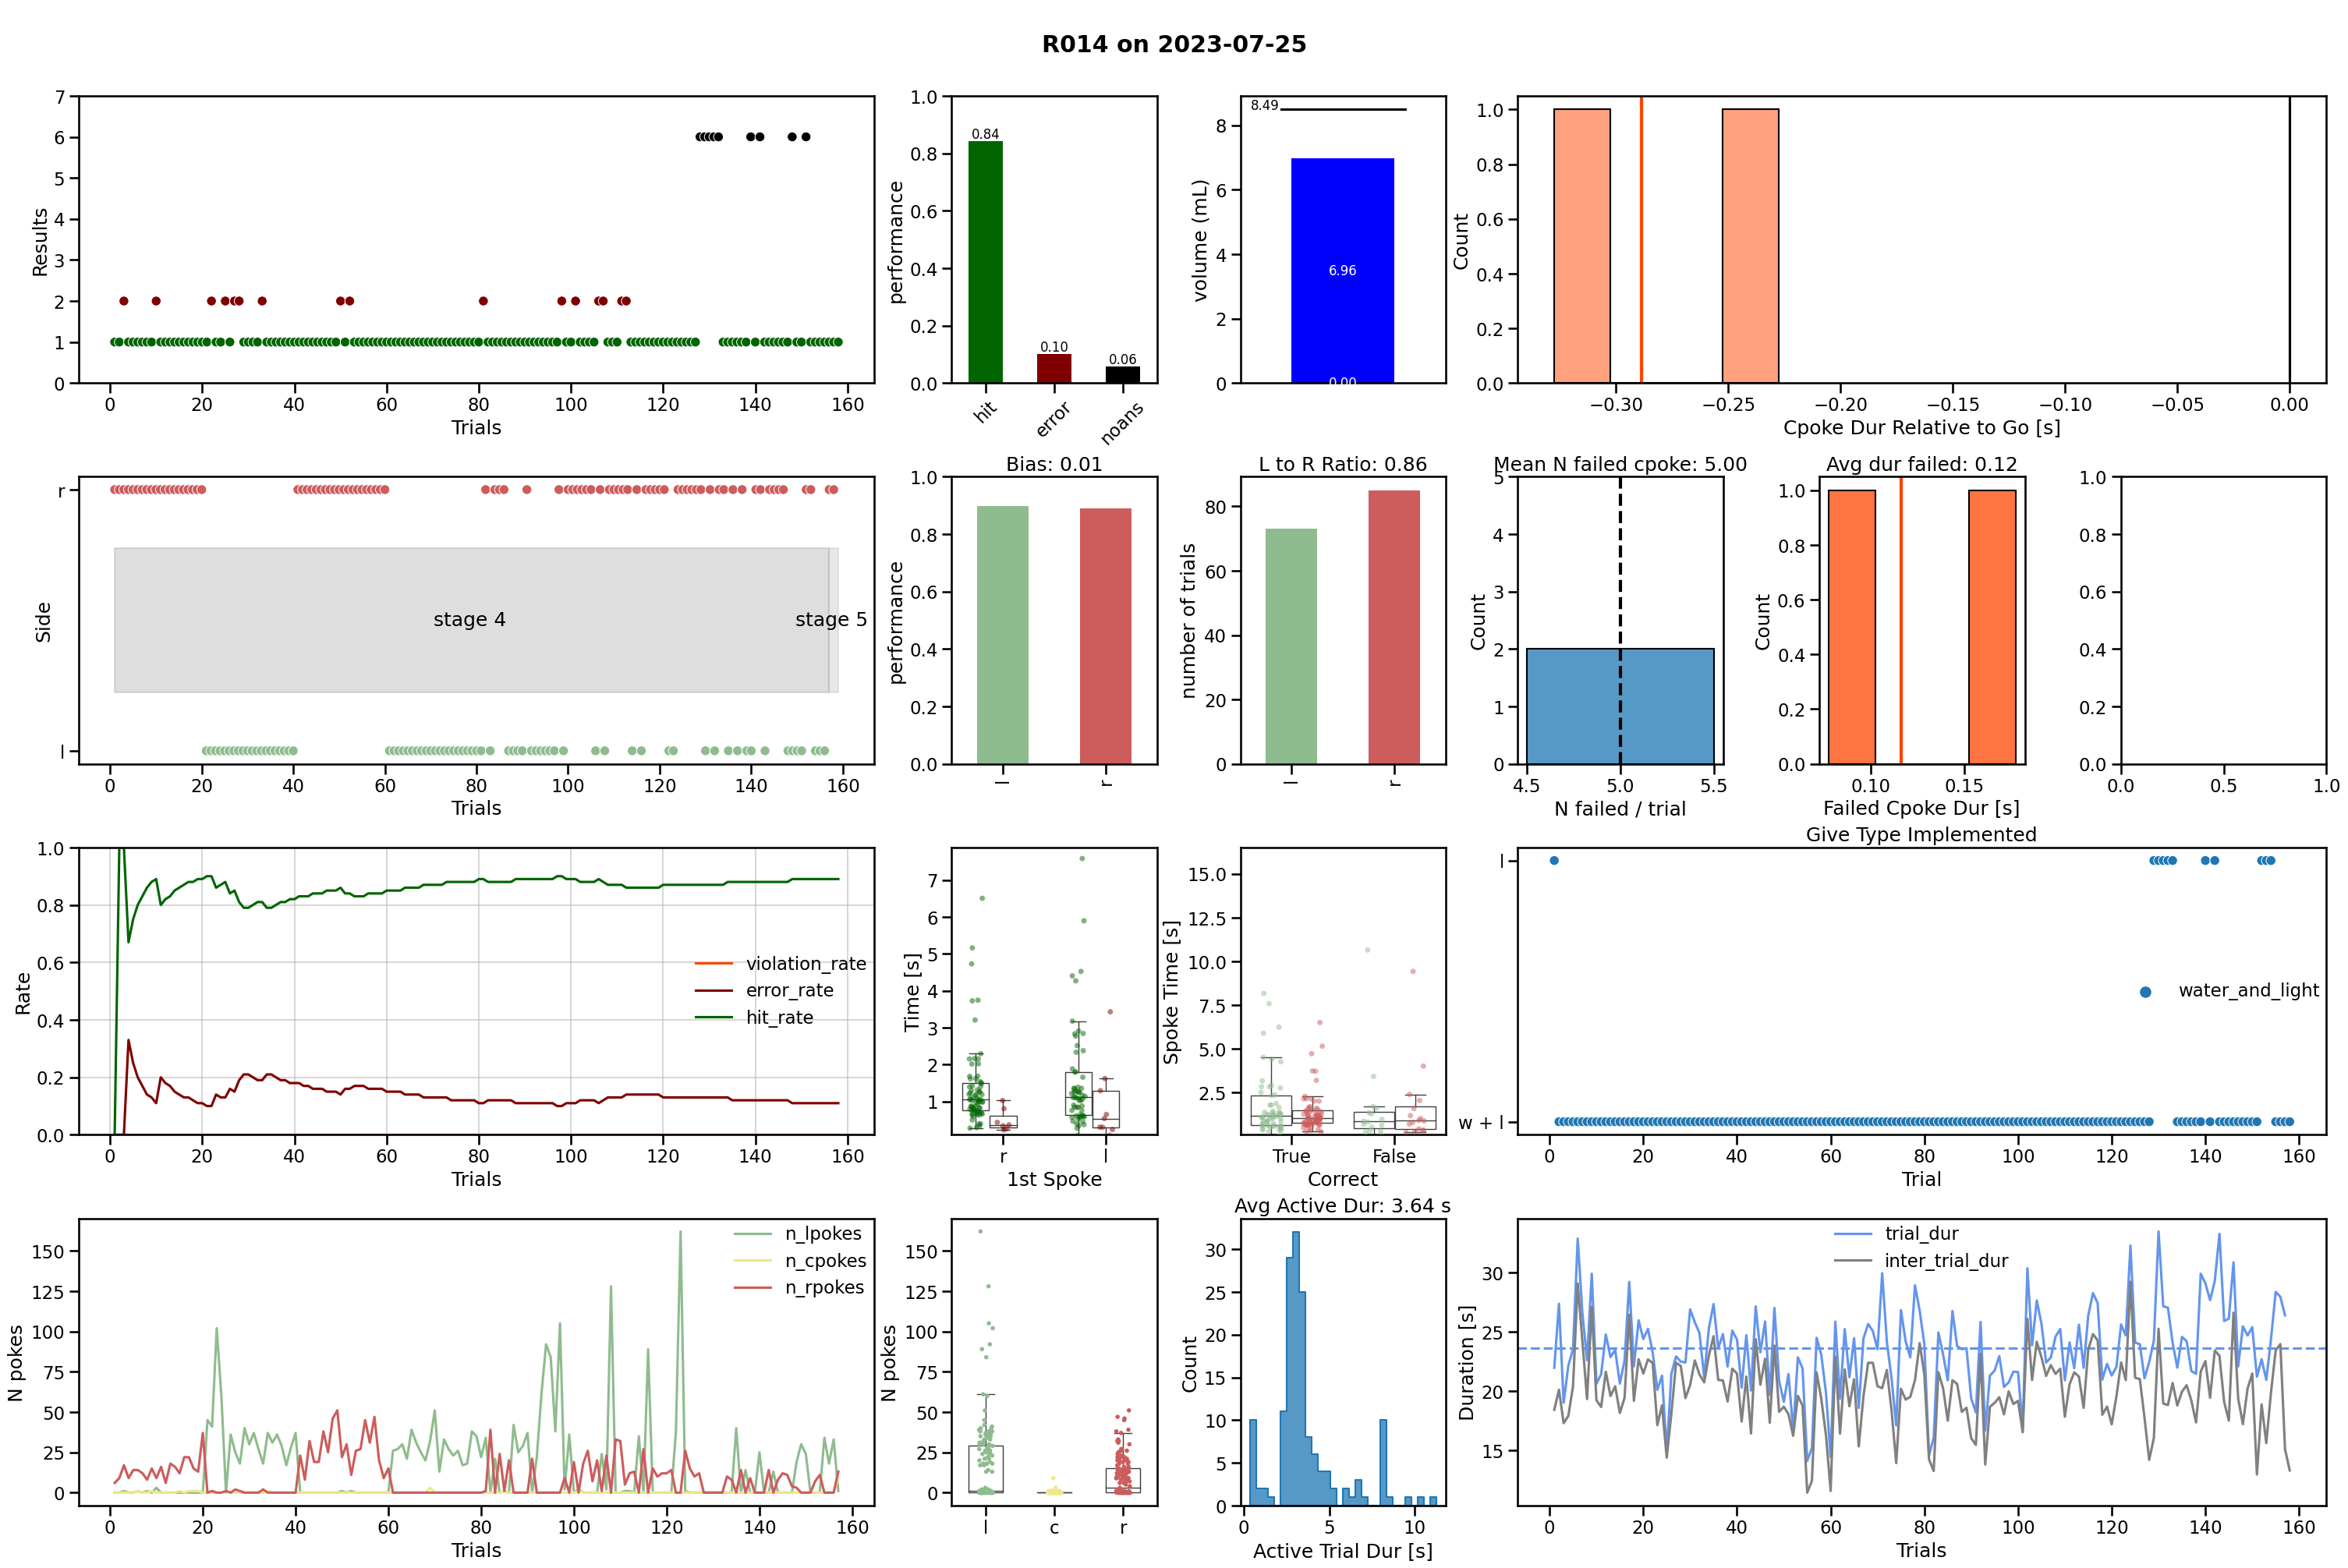

making R015_2023-07-25_day_summary
No valid cpokes, make sure fixation is on!


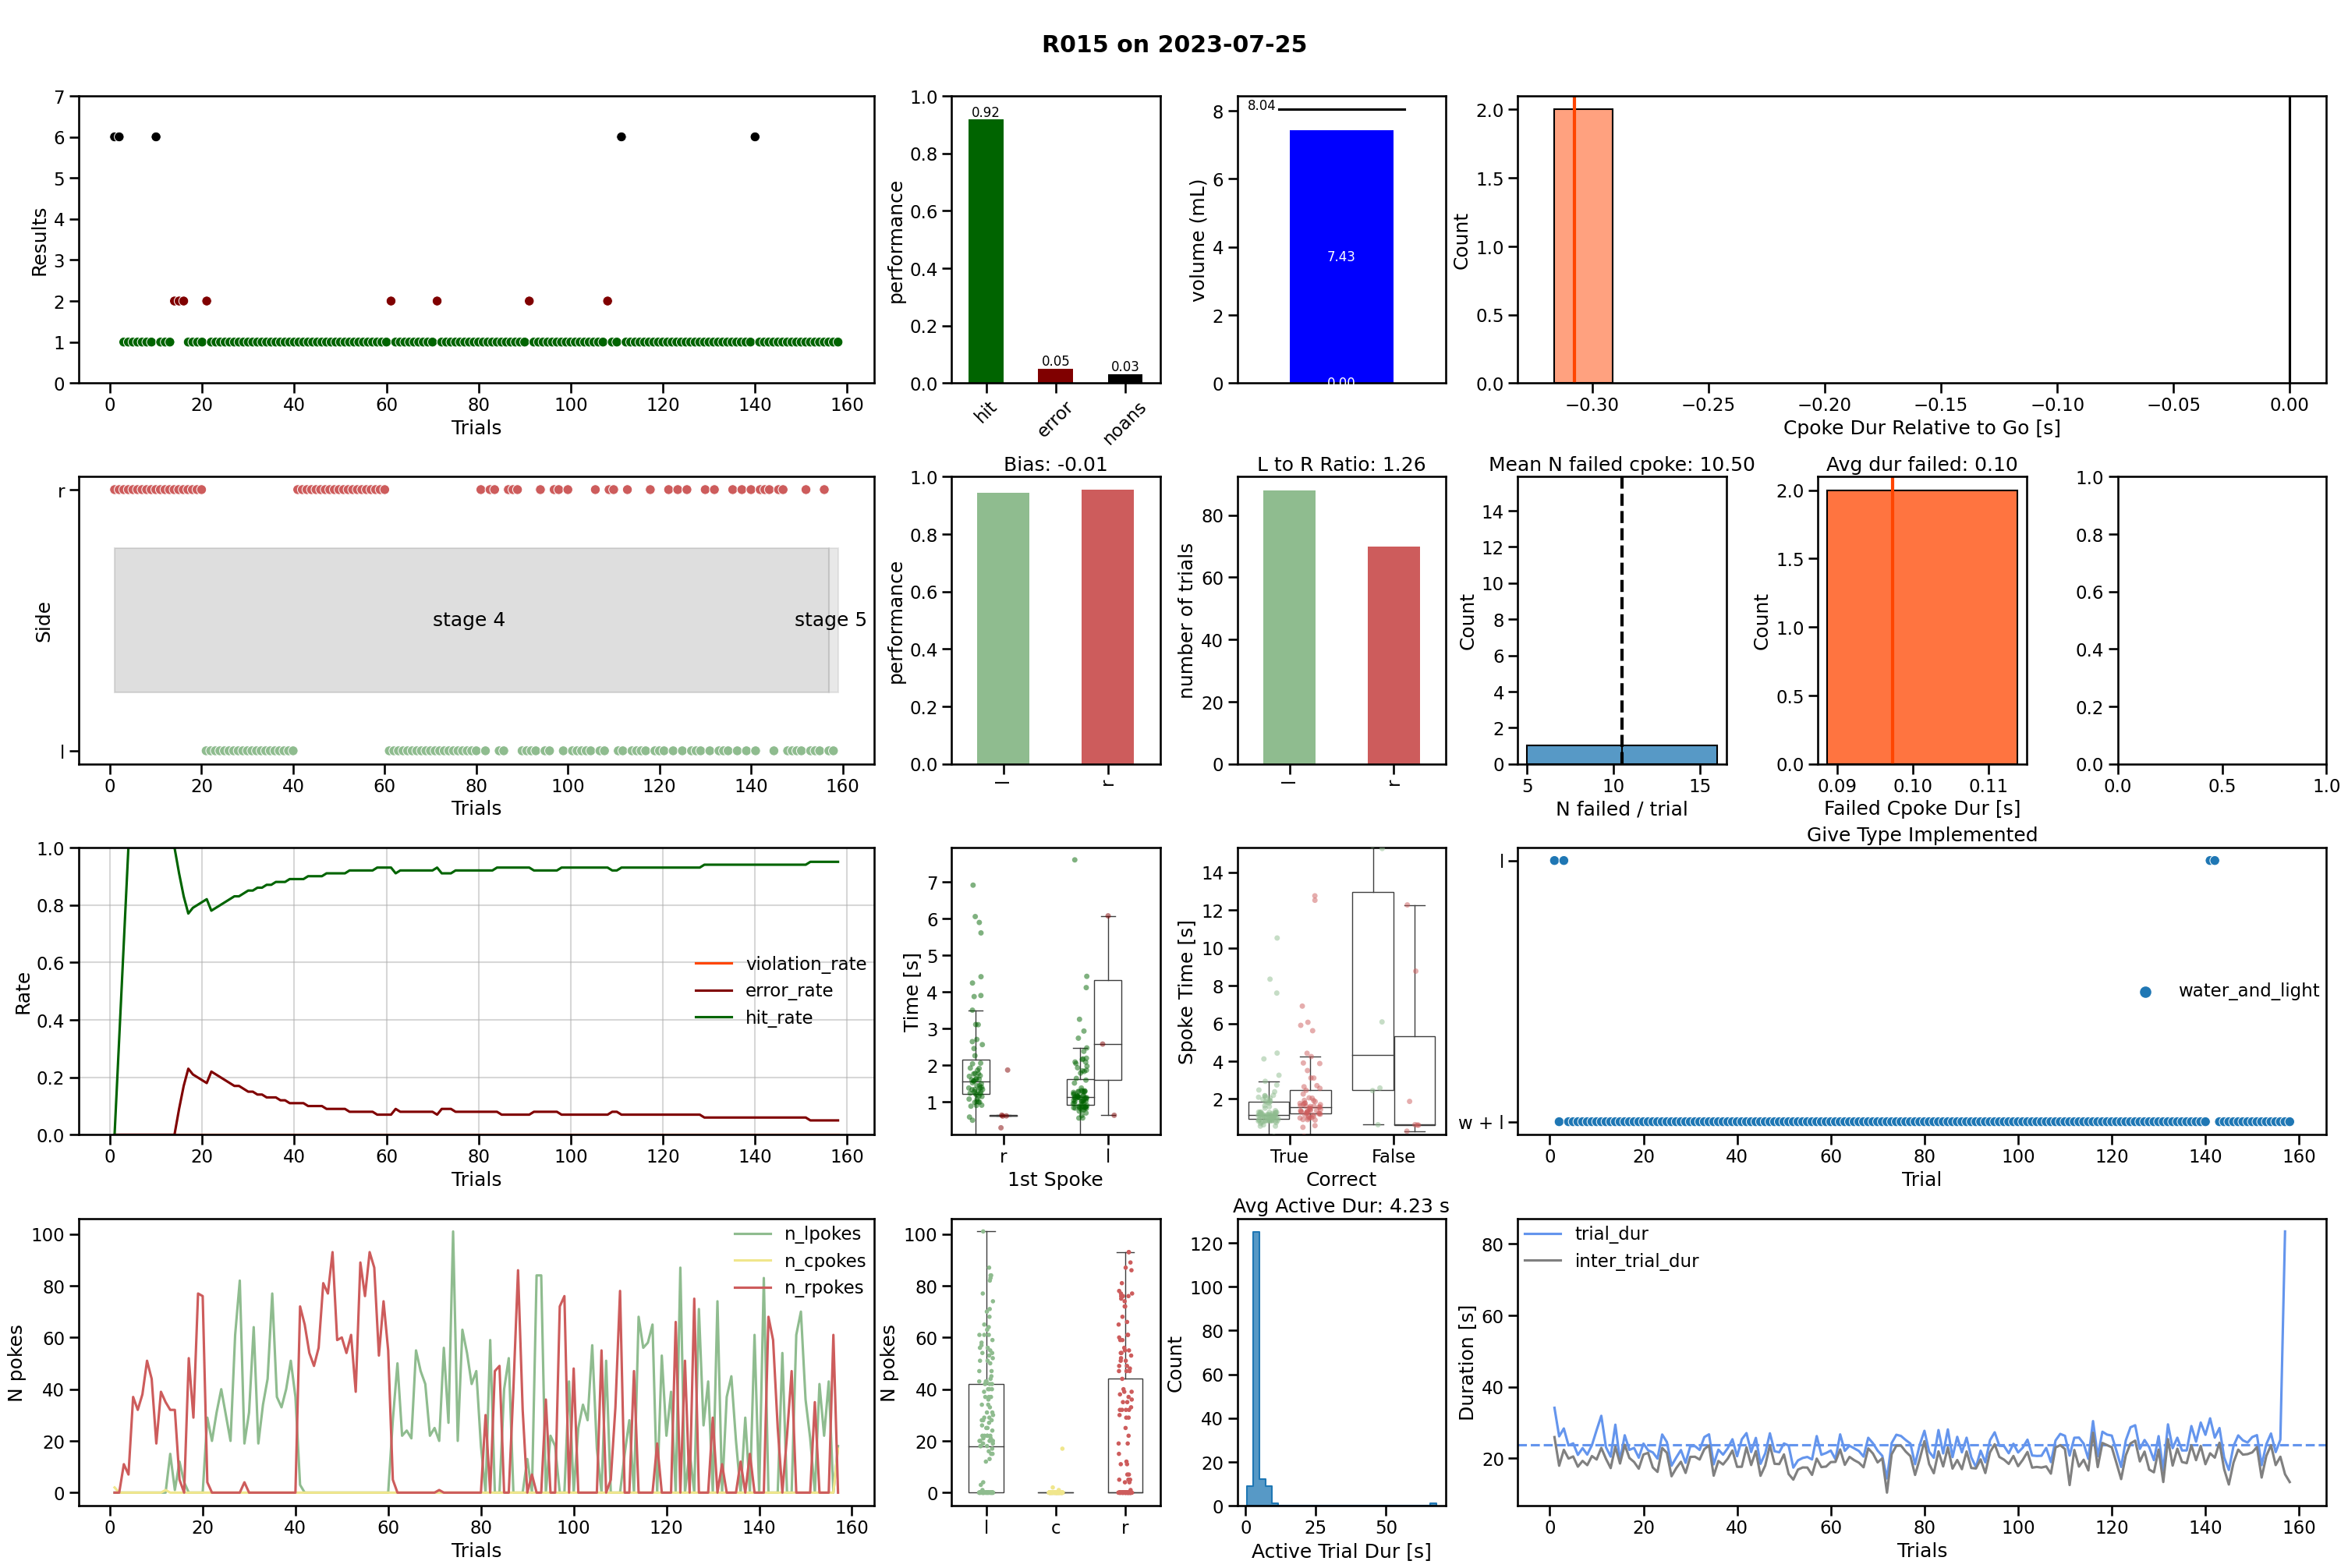

In [36]:
multiplot_single_day_summaries(df, figures_path=Path.cwd(), save_out=False)

In [31]:
def plot_give_info(trials_df, ax, legend=True):
    """
    plot give info for each trial. will plot the give type that
    was set by the GUI and the give type that was implemented by
    the underlying code (e.g. if fraction of give trials is not
    100%, then the give type set by the GUI will not match the
    type implemented every trial)

    params
    ------
    trials_df : DataFrame
        trials dataframe with columns `trial`, `give_type_imp`, and
        `give_type_set` with trials as row index
    ax : matplotlib.axes.Axes
        axis to plot to
    """

    # make the names shorter for plotting
    data = trials_df[["trial", "give_type_imp", "give_type_set"]].copy()
    mapping = {"water_and_light": "w + l", "water": "w", "light": "l", "none": "n"}
    data.give_type_imp = data.give_type_imp.replace(mapping)

    sns.scatterplot(data=data, x="trial", y="give_type_imp", hue="give_type_set", ax=ax)

    _ = ax.set(title="Give Type Implemented", xlabel="Trial", ylabel="")

    pu.set_legend(ax, legend)

    return None

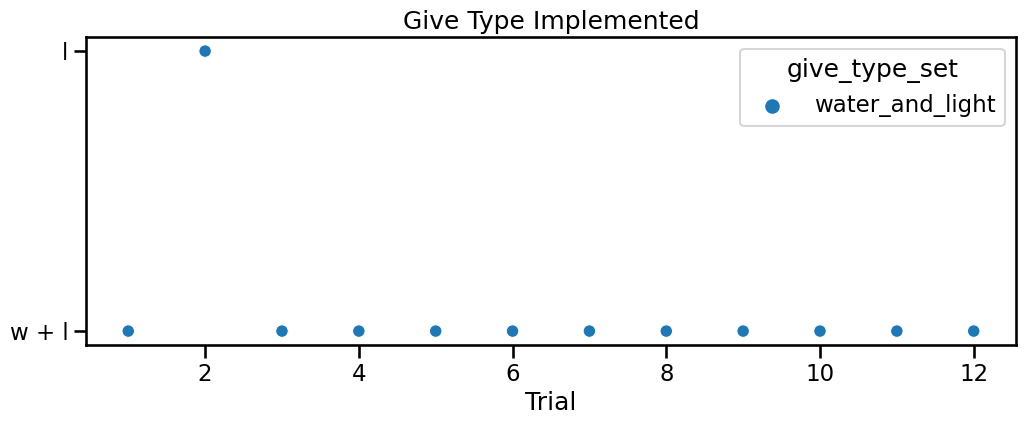

In [32]:
df.give_type_imp
fig, ax = make_fig()
# ? melt this with the go_type
data = df[["trial", "give_type_imp", "give_type_set"]].copy()
data

mapping = {"water_and_light": "w + l", "water": "w", "light": "l", "none": "n"}
data.give_type_imp = data.give_type_imp.replace(mapping)
sns.scatterplot(data=data, x="trial", y="give_type_imp", hue="give_type_set", ax=ax)
_ = ax.set(title="Give Type Implemented", xlabel="Trial", ylabel="")

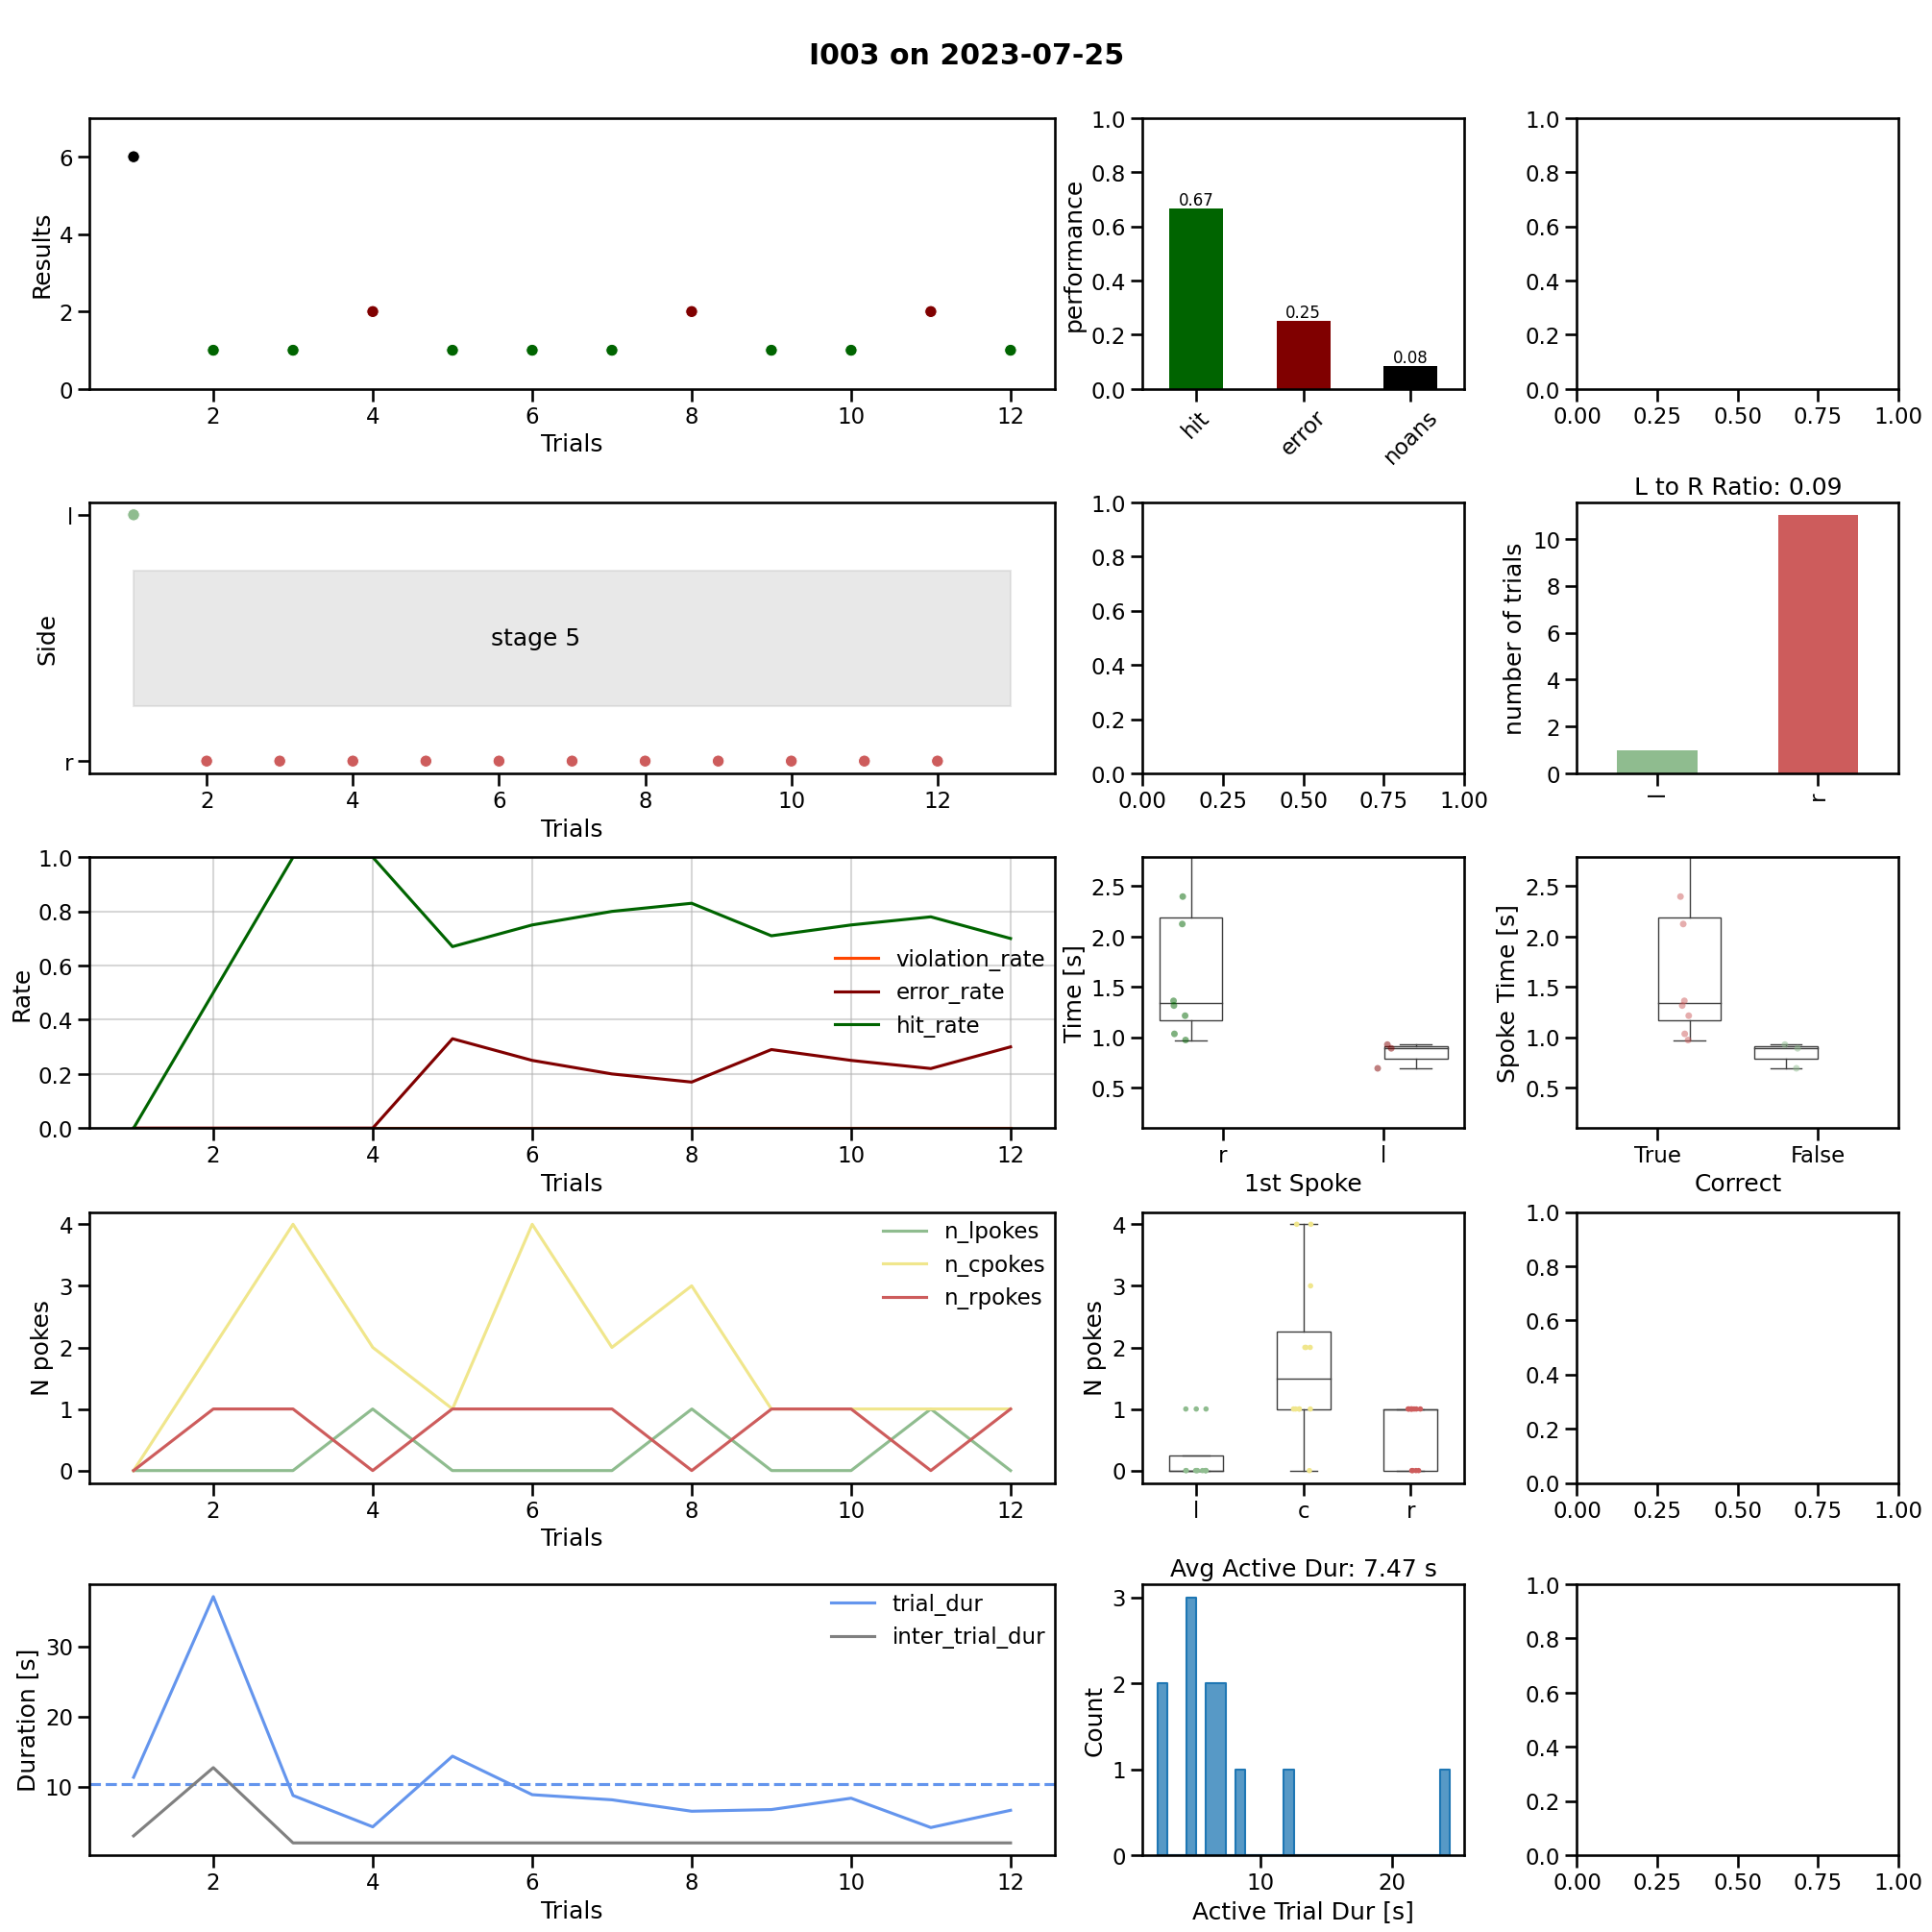

In [11]:
multiplot_spoke_lg(df, save_out=False)

In [33]:
def multiplot_cpoke_pre_gnp(trials_df, save_out=False, save_path=None):
    """
    generate summary plot for spoke stages given a light guide (lg)
    curriculum

    params
    ------
    trials_df : DataFrame
        trials dataframe generated by create_trials_df() for a single
        animal on a single date with trials as row index
    save_out : bool (default=False)
        whether to save out the figure
    save_path : str (default=None)
        path to save the figure to
    """
    layout = """
        AAABCDDD
        EEEFGHIJ
        KKKLMNNN
        OOOPQRRR
    """
    fig = plt.figure(constrained_layout=True, figsize=(30, 20))

    plt.suptitle(
        f"\n{trials_df.animal_id.iloc[0]} on {trials_df.date.iloc[0]}\n",
        fontweight="semibold",
    )
    ax_dict = fig.subplot_mosaic(layout)  # ax to plot to
    # identify_axes(ax_dict) # prints the letter for id

    ## ROW 1
    plot_results(trials_df, ax=ax_dict["A"])
    plot_result_summary(trials_df, ax=ax_dict["B"])
    # plot_watering_amounts(trials_df, ax=ax_dict["C"])
    plot_cpoke_distributions(trials_df, ax=ax_dict["D"], mode="settling_in")

    ## ROW 2
    plot_correct_side(trials_df, ax=ax_dict["E"])
    plot_stage_info(trials_df, ax=ax_dict["E"])
    # plot_side_bias_summary(trials_df, ax=ax_dict["F"])
    plot_side_count_summary(trials_df, ax=ax_dict["G"])
    plot_n_failed_cpokes(trials_df, ax=ax_dict["H"])
    plot_avg_failed_cpoke_dur(trials_df, ax=ax_dict["I"])
    plot_avg_valid_cpoke_dur(trials_df, ax=ax_dict["J"])

    ## ROW 3
    plot_performance_rates(trials_df, ax=ax_dict["K"])
    plot_first_spoke_summary_by_loc_and_result(trials_df, ax=ax_dict["L"])
    plot_first_spokes_summary_by_correct_side_and_loc(trials_df, ax=ax_dict["M"])
    plot_give_info(trials_df, ax=ax_dict["N"])

    ## ROW 4
    plot_npokes(trials_df, ax=ax_dict["O"])
    plot_npokes_summary(trials_df, ax=ax_dict["P"])
    plot_active_trial_dur_summary(trials_df, ax=ax_dict["Q"])
    plot_trial_dur(trials_df, ax=ax_dict["R"])

    # plot L here

    if save_out:
        plt.savefig(save_path, bbox_inches="tight")
        plt.close("all")
    else:
        plt.show()

    return None

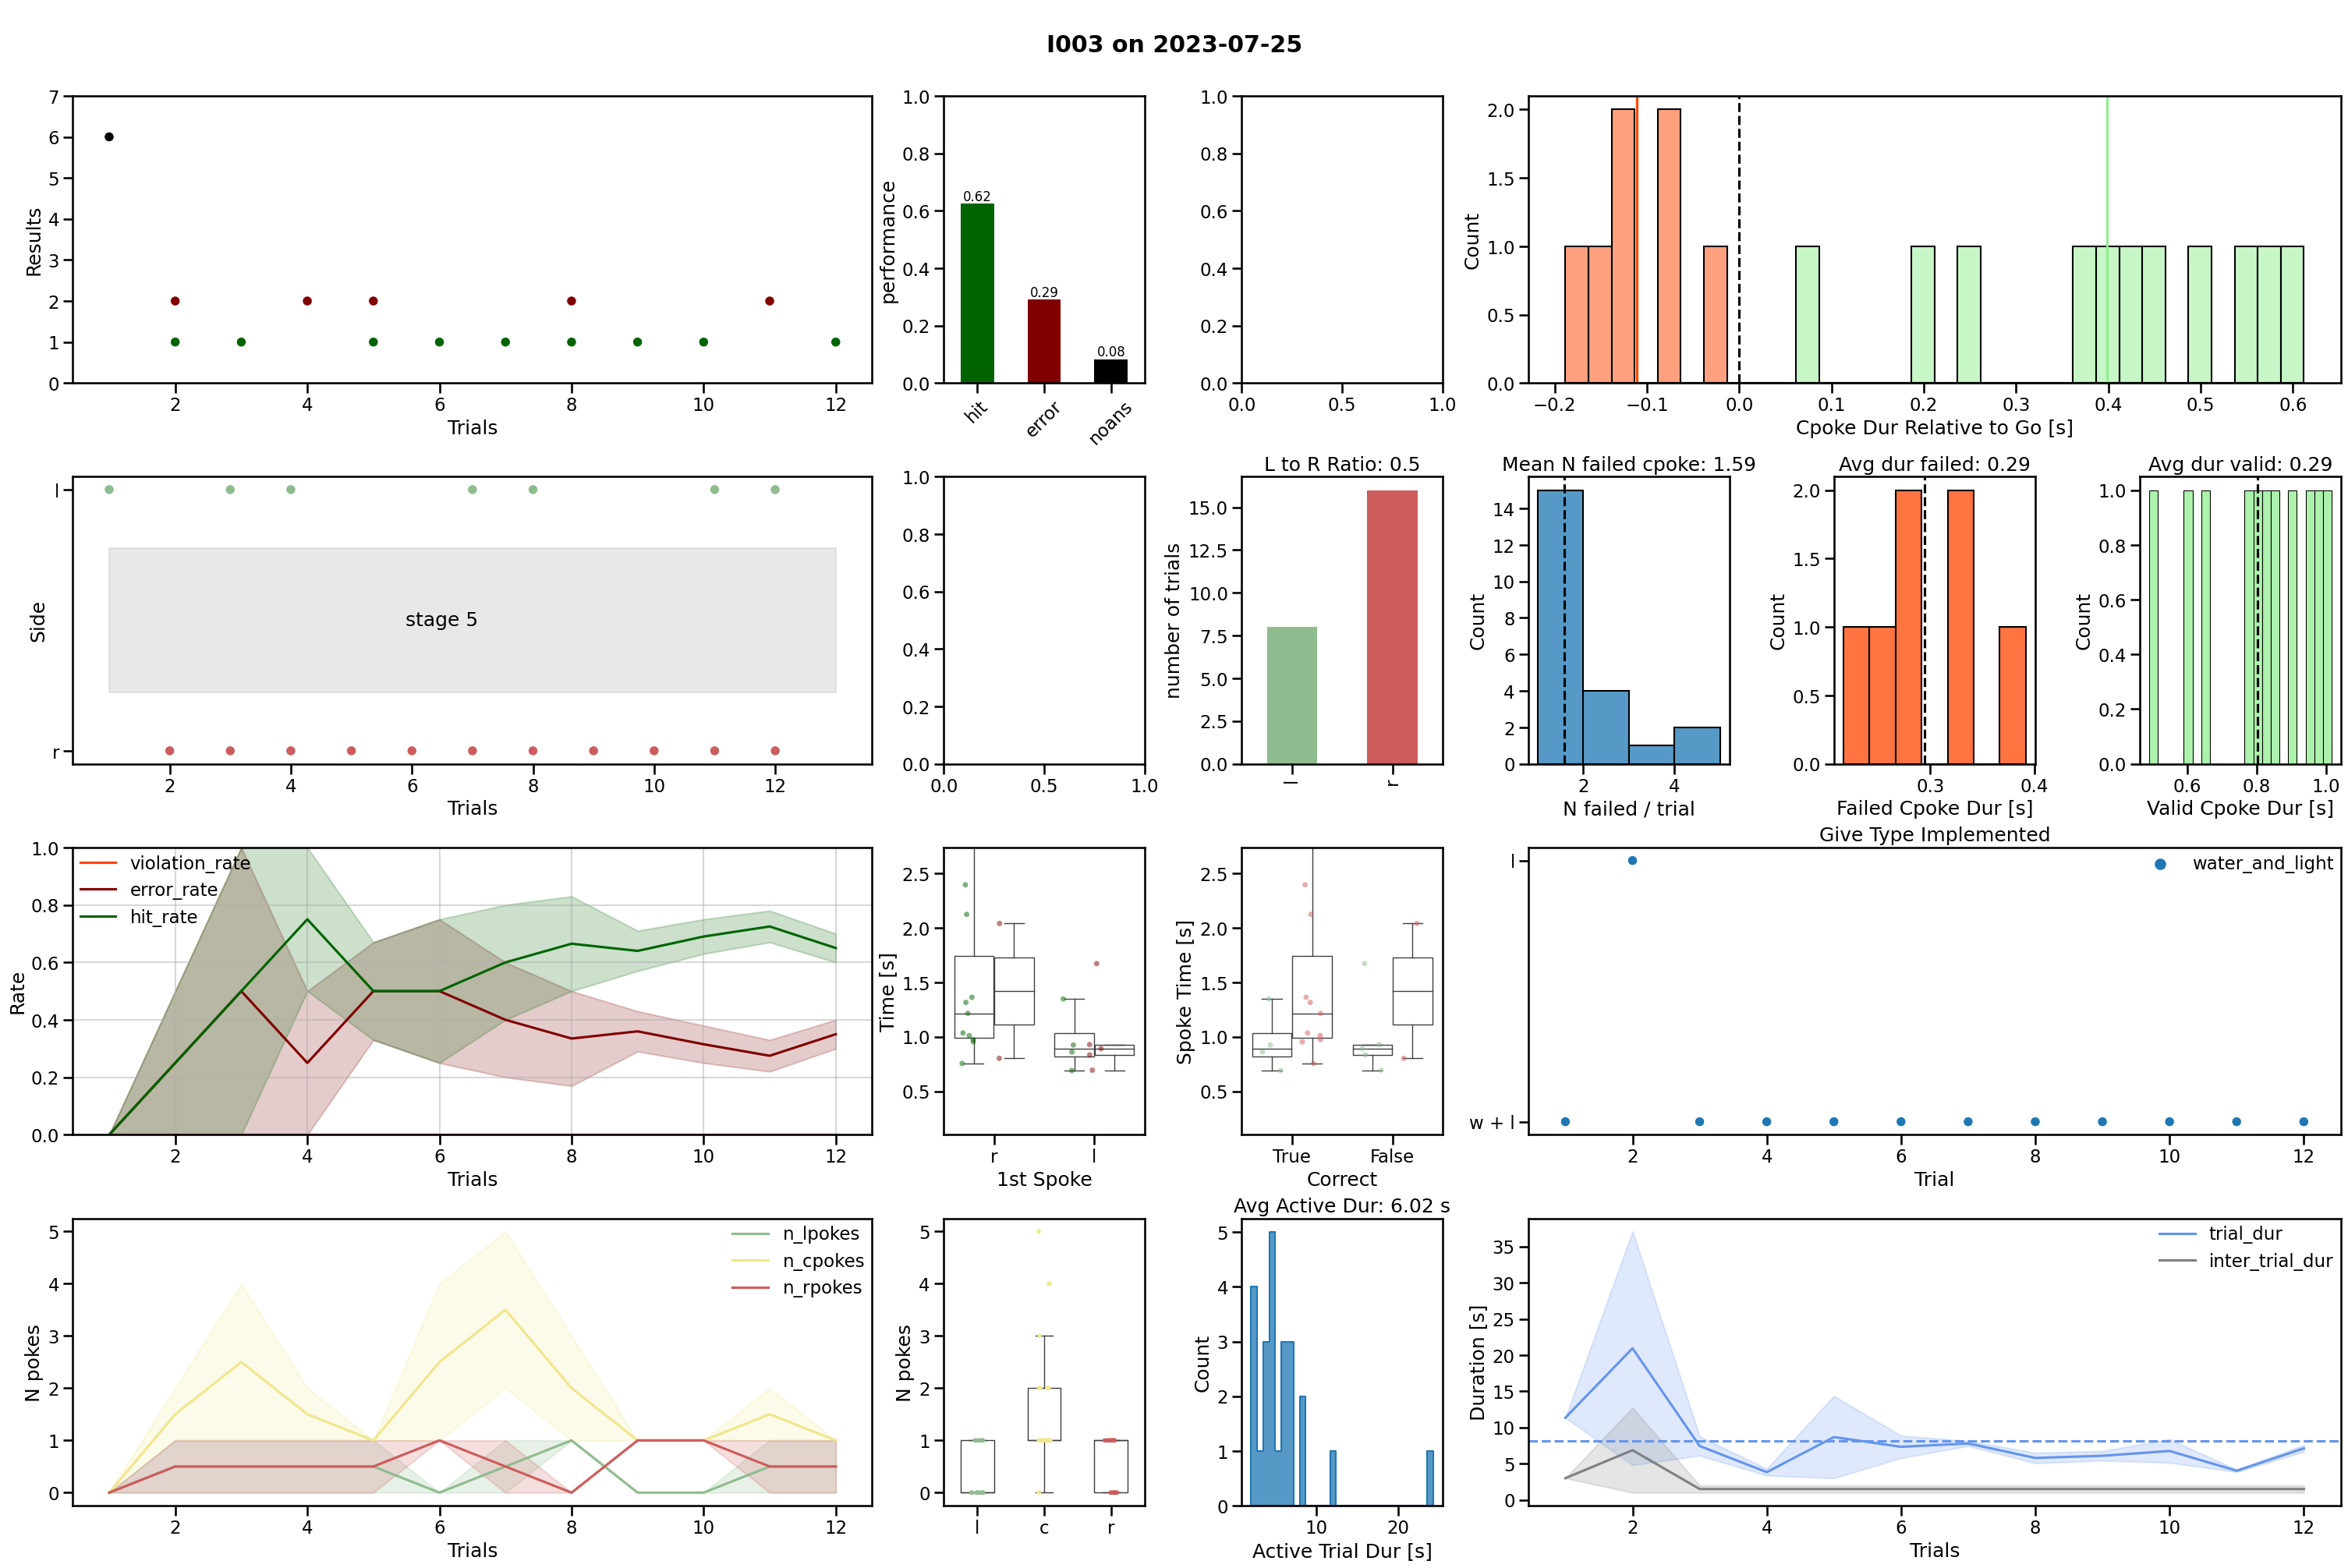

In [34]:
multiplot_cpoke_pre_gnp(df)

## Stopped here-
 things look good. left to do is to make some logic in multiplot_single_day_summaries to pick this plot. Maybe if SMA=cpoke and stimuli_on = 0. Also want to add in a 'give plot for the empty box to show for each trial what the give was. For mutliday plots, having active dur, mean number of failed, avg dur failed avg dur valid would be helpful and a stacked bar plot with the give proportions

In [ ]:
# dm = df.date.min()
# dm2 = pd.Timestamp(2023, 4, 15).date()
# dm3 = pd.Timestamp(2023, 7, 10).date()
# dmax = df.date.max()
# day = df.query("date == @dm")
# day2 = df.query("date == @dm2")
# dayl = df.query("date == @dm3")

# trials_df = dayl

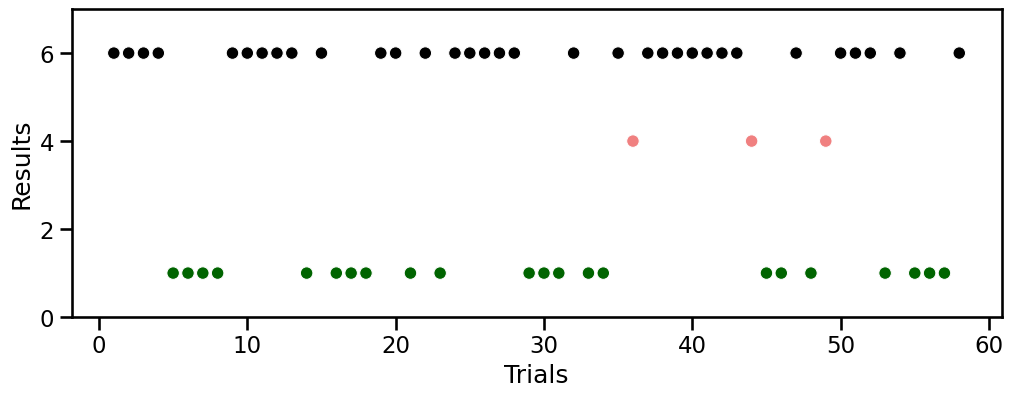

In [ ]:
fig, ax = make_fig()
plot_results(df.query("animal_id == 'R511'"), ax)

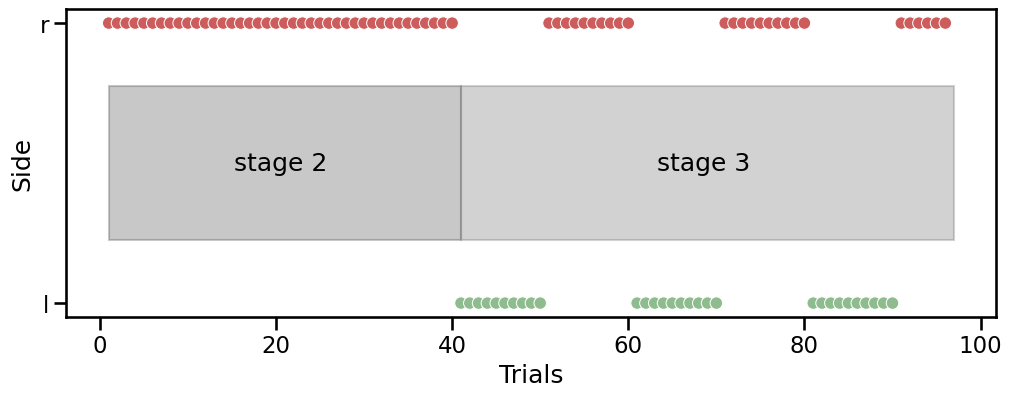

In [ ]:
fig, ax = make_fig()
plot_stage_info(trials_df, ax)
plot_correct_side(trials_df, ax)

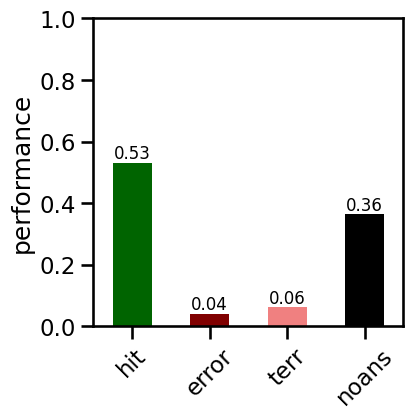

In [ ]:
f, a = make_fig("s")

plot_result_summary(trials_df, a)

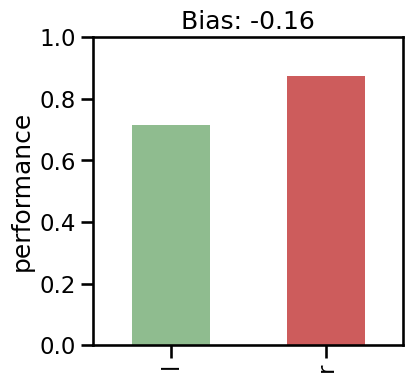

In [ ]:
f, ax = make_fig("s")
plot_side_bias_summary(trials_df, ax)

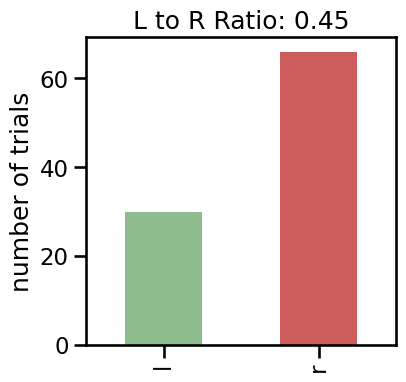

In [ ]:
f, ax = make_fig("s")
plot_side_count_summary(trials_df, ax)

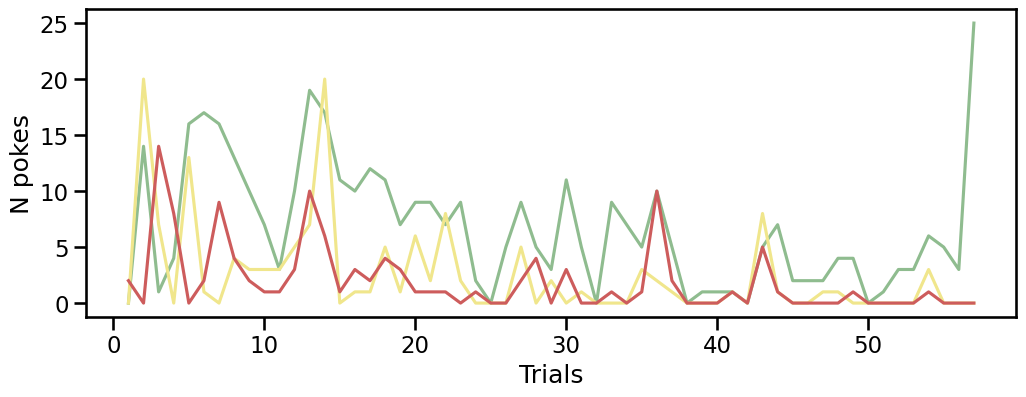

In [10]:
fig, ax = make_fig()
plot_npokes(r, ax, title="", legend=False)

In [11]:
r.min_time_to_spoke

0     17.2962
1     23.7084
2     23.0794
3     17.5326
4      1.7766
5      3.9586
6      0.1527
7      4.7793
8     15.3740
9      9.3286
10    18.3162
11     9.2772
12    12.6630
13     1.2962
14     8.5187
15     1.6012
16     5.0305
17     0.9956
18    20.0340
19    14.1803
20     4.0973
21     9.0989
22     2.6935
23    10.8108
24        NaN
25    10.3763
26    11.0969
27    10.2688
28     7.6601
29     1.6385
30     6.9920
31        NaN
32     4.3467
33     7.8622
34    11.2123
35     7.9823
36     9.1995
37        NaN
38    12.9660
39    13.7364
40    17.4545
41        NaN
42    19.9619
43     7.6478
44     4.5422
45     2.1061
46    19.1495
47     0.0275
48     3.1760
49        NaN
50    46.7145
51    17.3323
52     2.1656
53    12.6822
54     7.9549
55     2.1450
56     1.1411
57    11.1972
Name: min_time_to_spoke, dtype: float64

c:\Users\JB\github\jbreda_animal_training\code\training_performance\dj_exploratory_notebooks\..\plot_trials_info.py:343: FutureWarning: Passing `palette` without assigning `hue` is deprecated.
  sns.stripplot(
c:\Users\JB\github\jbreda_animal_training\code\training_performance\dj_exploratory_notebooks\..\plot_trials_info.py:343: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.stripplot(


ValueError: min() arg is an empty sequence

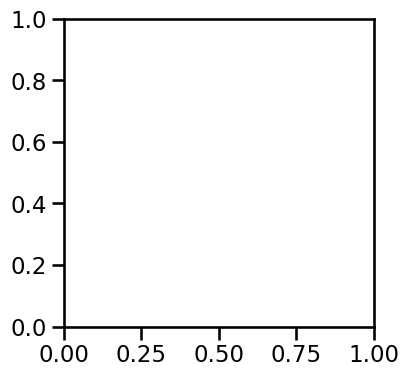

In [6]:
fig, ax = make_fig("s")
plot_npokes_summary(r, ax, title="")

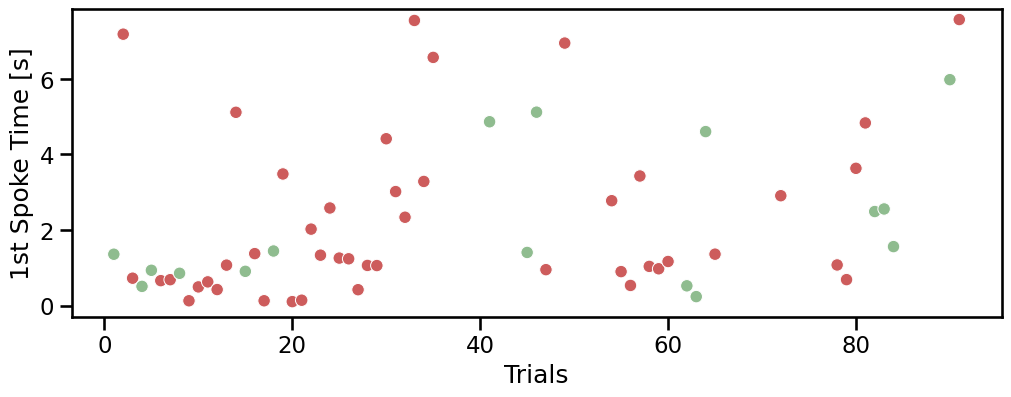

In [ ]:
fig, ax = make_fig()
plot_time_to_first_spoke(trials_df, ax)

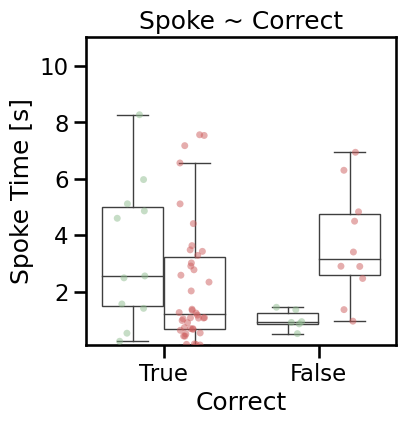

In [ ]:
fig, ax = make_fig("s")

plot_first_spokes_summary_by_correct_side_and_loc(
    trials_df, ax, title="Spoke ~ Correct", legend=False
)

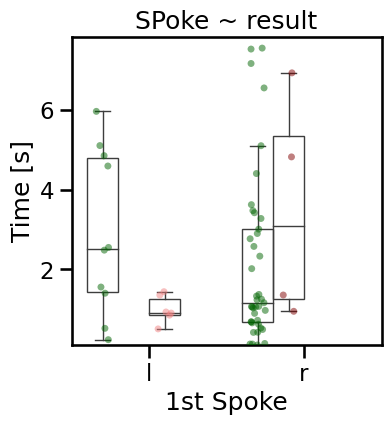

In [ ]:
fig, ax = make_fig("s")

plot_first_spoke_summary_by_loc_and_result(
    trials_df, ax, title="SPoke ~ result", legend=False
)

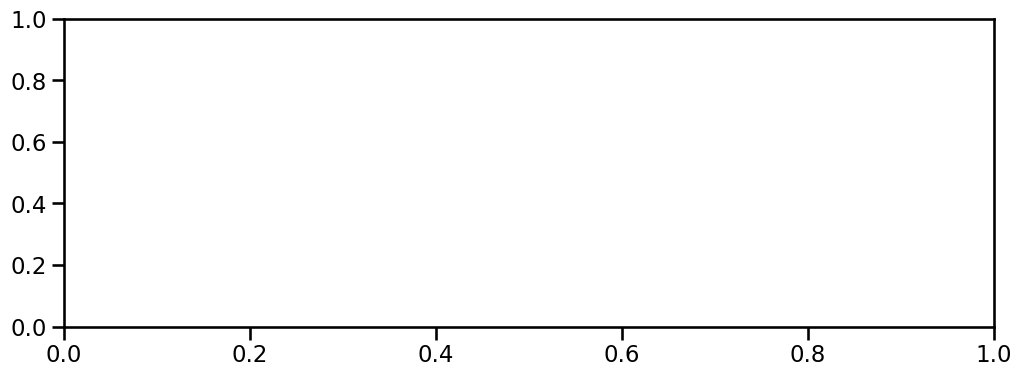

In [ ]:
fig, ax = make_fig()

# plot_in(trials_df, ax)

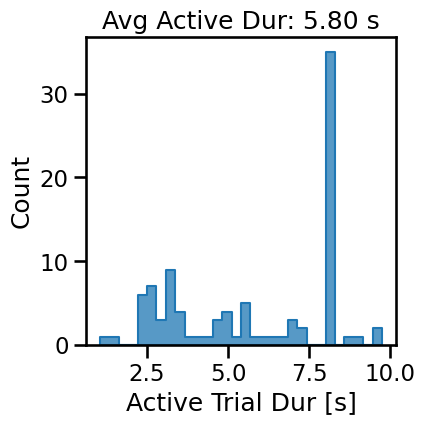

In [ ]:
fig, ax = make_fig("s")
plot_active_trial_dur_summary(trials_df, ax)

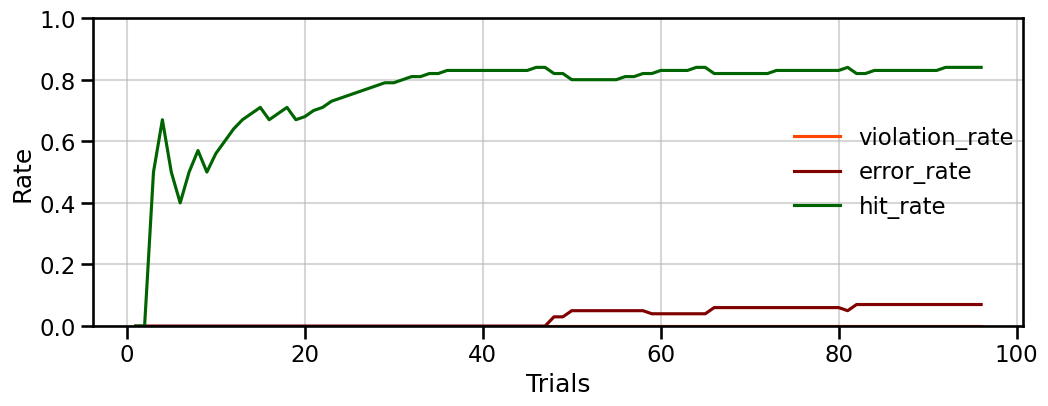

In [ ]:
f, ax = make_fig()
plot_performance_rates(trials_df, ax)

NameError: name 'dayl' is not defined

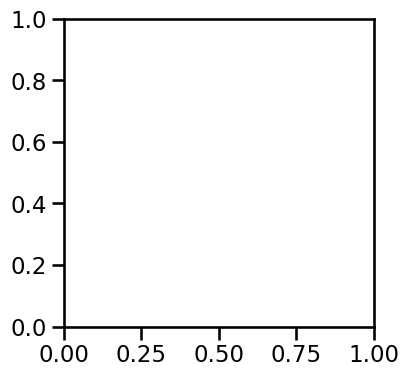

In [ ]:
fig, ax = make_fig("s")
plot_watering_amounts(dayl, ax, legend=False)

In [24]:
def multiplot_spoke_lg(trials_df, save_out=False, save_path=None):
    """
    generate summary plot for spoke stages given a light guide (lg)
    curriculum

    params
    ------
    trials_df : DataFrame
        trials dataframe generated by create_trials_df() for a single
        animal on a single date with trials as row index
    save_out : bool (default=False)
        whether to save out the figure
    save_path : str (default=None)
        path to save the figure to
    """
    layout = """
        AAABC
        DDDEF
        GGGHI
        JJJKL
        MMMNP
    """
    fig = plt.figure(constrained_layout=True, figsize=(20, 20))

    plt.suptitle(
        f"\n{trials_df.animal_id.iloc[0]} on {trials_df.date.iloc[0]}\n",
        fontweight="semibold",
    )
    ax_dict = fig.subplot_mosaic(layout)  # ax to plot to
    # identify_axes(ax_dict) # prints the letter for id

    ## ROW 1
    plot_results(trials_df, ax=ax_dict["A"])
    plot_result_summary(trials_df, ax=ax_dict["B"])
    plot_watering_amounts(trials_df, ax=ax_dict["C"])

    ## ROW 2
    plot_correct_side(trials_df, ax=ax_dict["D"])
    plot_stage_info(trials_df, ax=ax_dict["D"])
    plot_side_bias_summary(trials_df, ax=ax_dict["E"])
    plot_side_count_summary(trials_df, ax=ax_dict["F"])

    ## ROW 3
    plot_performance_rates(trials_df, ax=ax_dict["G"])
    plot_first_spoke_summary_by_loc_and_result(trials_df, ax=ax_dict["H"])
    plot_first_spokes_summary_by_correct_side_and_loc(trials_df, ax=ax_dict["I"])

    ## ROW 4
    plot_npokes(trials_df, ax=ax_dict["J"])
    plot_npokes_summary(trials_df, ax=ax_dict["K"])
    # plot L here

    ## ROW 5
    plot_trial_dur(trials_df, ax=ax_dict["M"])
    plot_active_trial_dur_summary(trials_df, ax=ax_dict["N"])
    # plot P here

    if save_out:
        plt.savefig(save_path, bbox_inches="tight")
        plt.close("all")
    else:
        plt.show()

    return None

In [ ]:
dd = df.query("animal_id == 'R511'")

In [ ]:
xx = create_trials_df_from_dj(["R610", "R611"], date_min="2023-07-09")

fetched 4 sessions for R610 between 2023-07-09 and 2023-07-12
fetched 4 sessions for R611 between 2023-07-09 and 2023-07-12


In [ ]:
for (date, animal_id), sub_df in xx.groupby(["date", "animal_id"]):
    print(date, animal_id)

2023-07-09 R610
2023-07-09 R611
2023-07-10 R610
2023-07-10 R611
2023-07-11 R610
2023-07-11 R611
2023-07-12 R610
2023-07-12 R611


In [15]:
FIGURE_PATH = Path(
    "C:\\Users\\JB\\github\\jbreda_animal_training\\figures\\mice\\cohort3"
)

# for string in ANIMAL_IDS:
#     Path(FIGURE_PATH, string).mkdir(parents=True, exist_ok=True)

In [45]:
# iterate over one animal, all dates
for (animal_id, date), sub_df in xx.groupby(["animal_id", "date"]):
    print(date, animal_id)



2023-07-09 R610
2023-07-10 R610
2023-07-11 R610
2023-07-12 R610
2023-07-09 R611
2023-07-10 R611
2023-07-11 R611
2023-07-12 R611


In [23]:
full_path[:-4]

TypeError: 'WindowsPath' object is not subscriptable

In [27]:
overwrite = False
# iterator over all animals, all dates

# TODO- update saving logic. If I want to have specific folders for each
# animal, day I will need to generate new full_paths according to this
# it might be handy to use the "animals" table i was making to infer where
# plot should go (ie mice or rats folder)

for (date, animal_id), sub_df in df.groupby(["date", "animal_id"]):
    fig_name = f"{animal_id}_{date}_trial_summary.png"
    full_path = FIGURE_PATH / fig_name

    if not Path.exists(full_path) or overwrite:
        
        print(f"making {fig_name[:-4]}")

        # TODO if/else logic here (or wrapper function) given new curricula
        multiplot_spoke_lg(sub_df, save_out=True, save_path=full_path)

R511


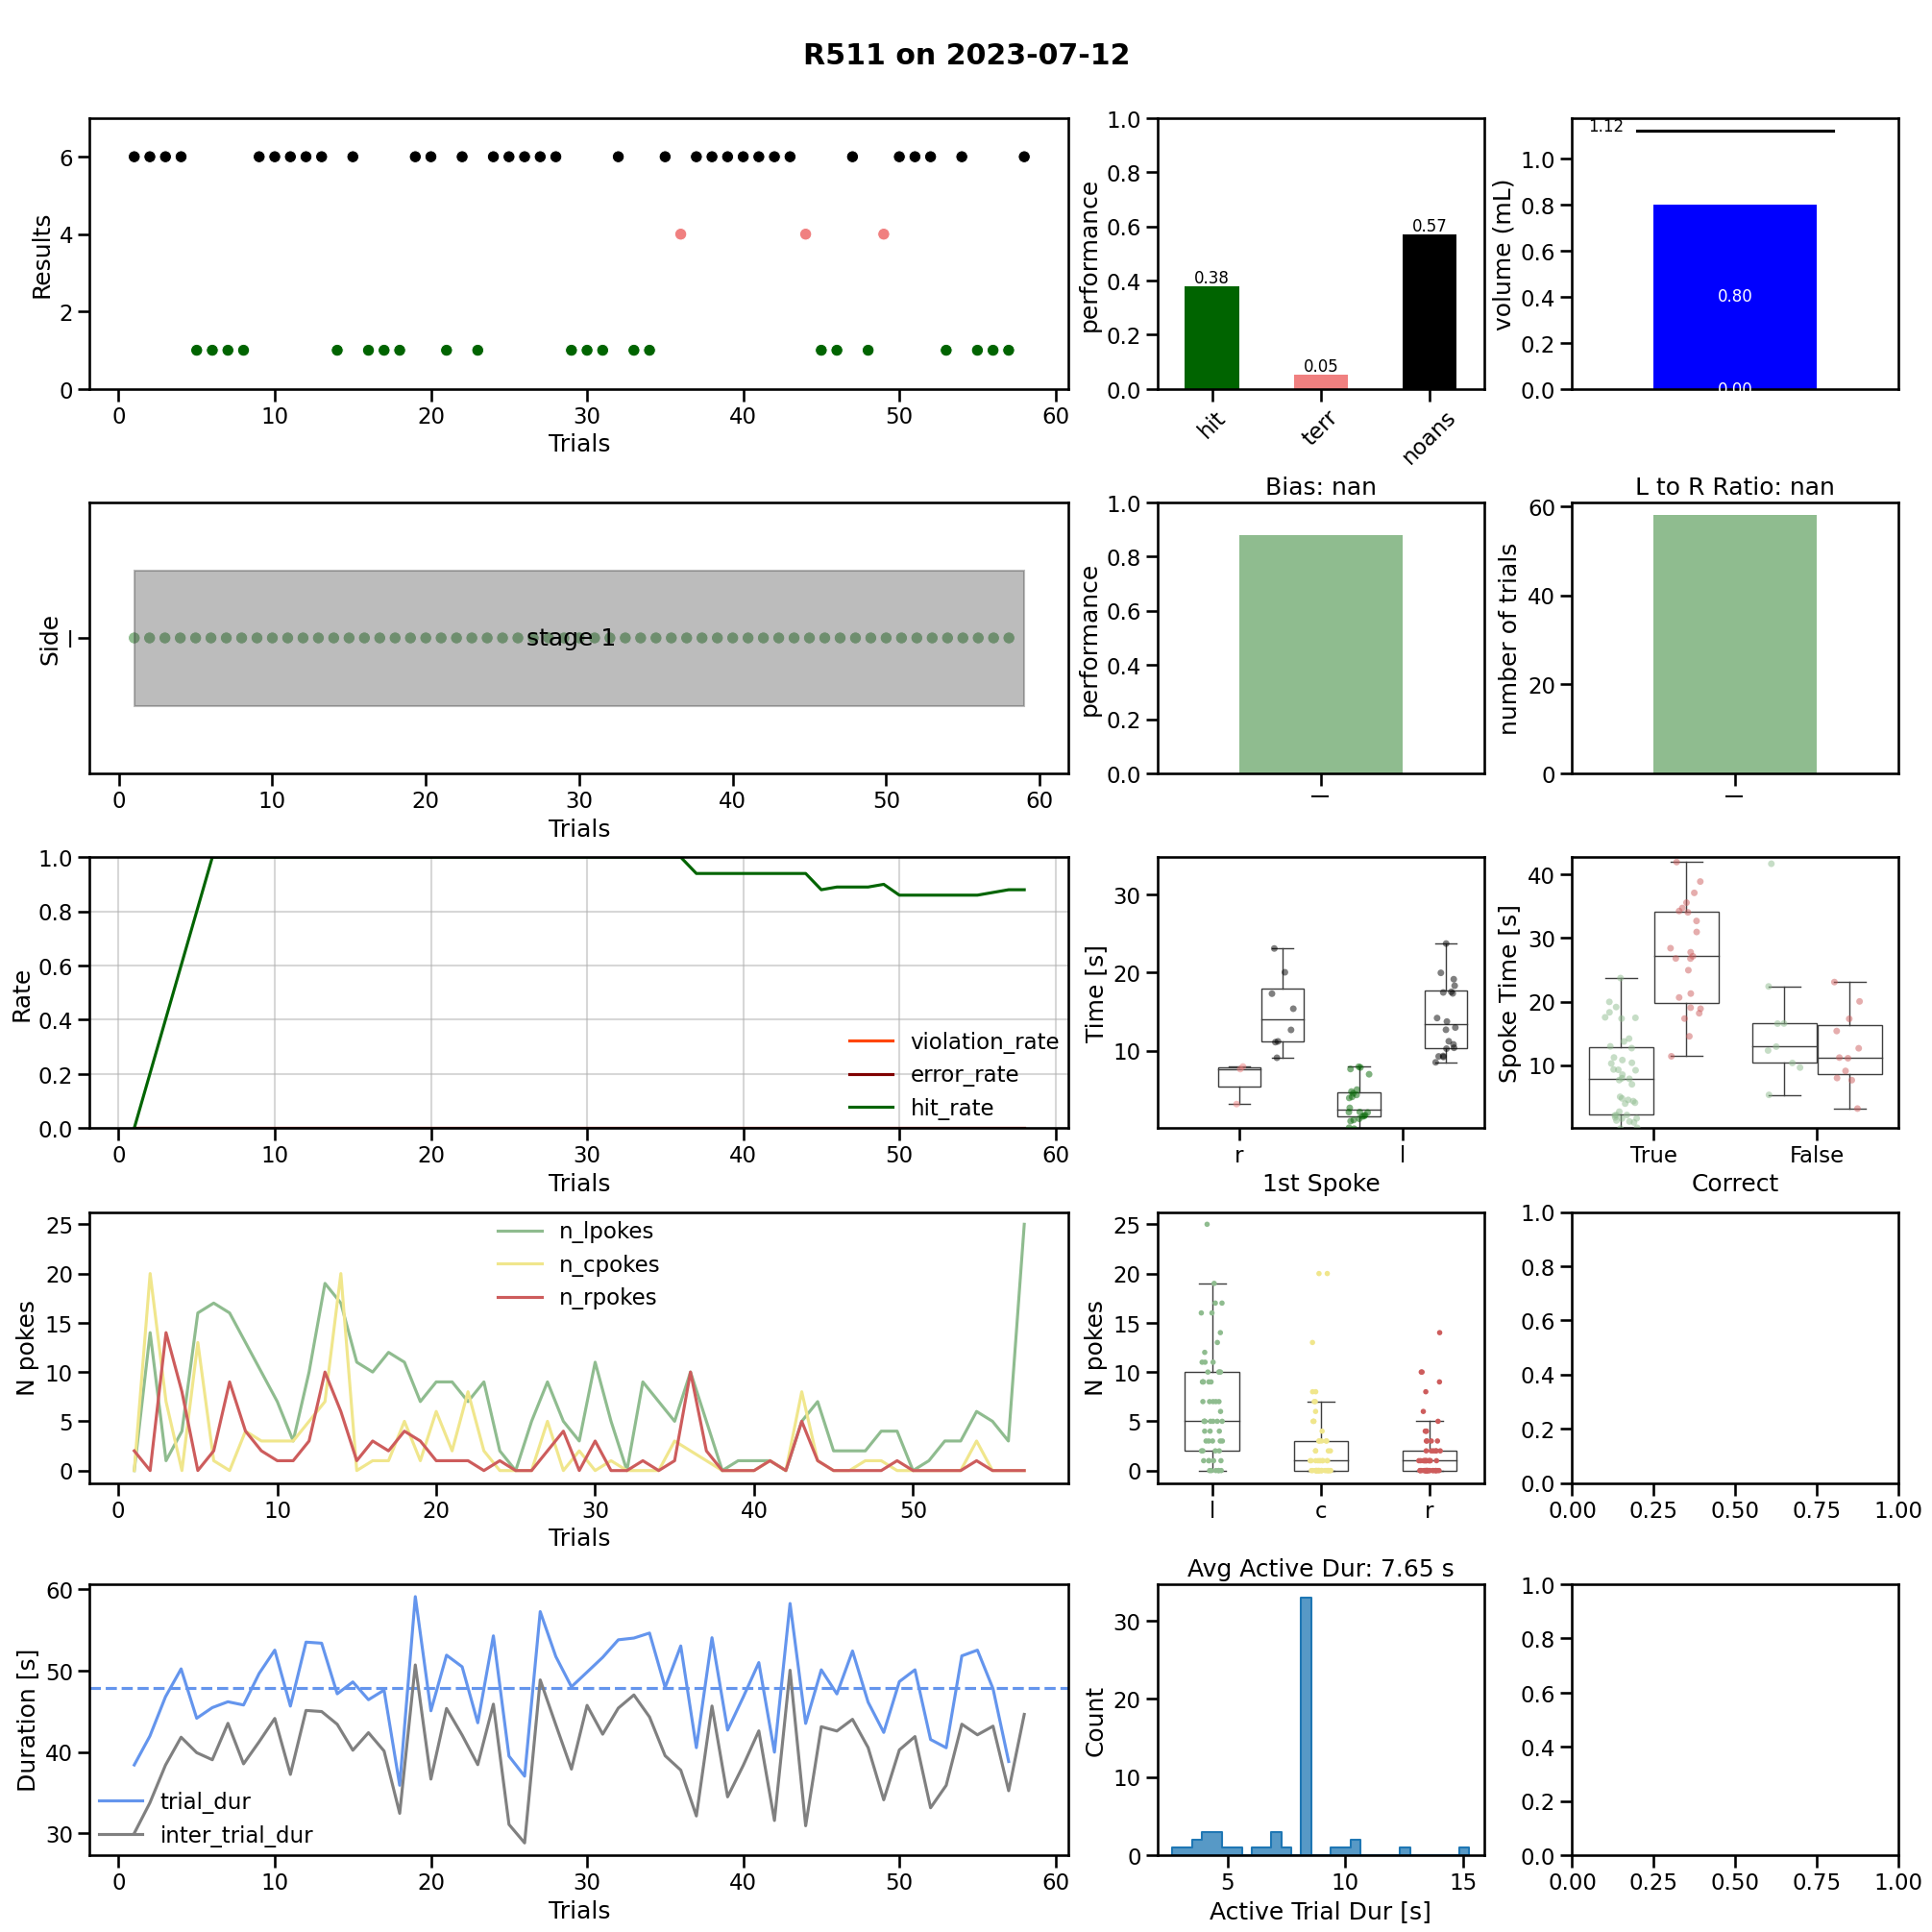

R512


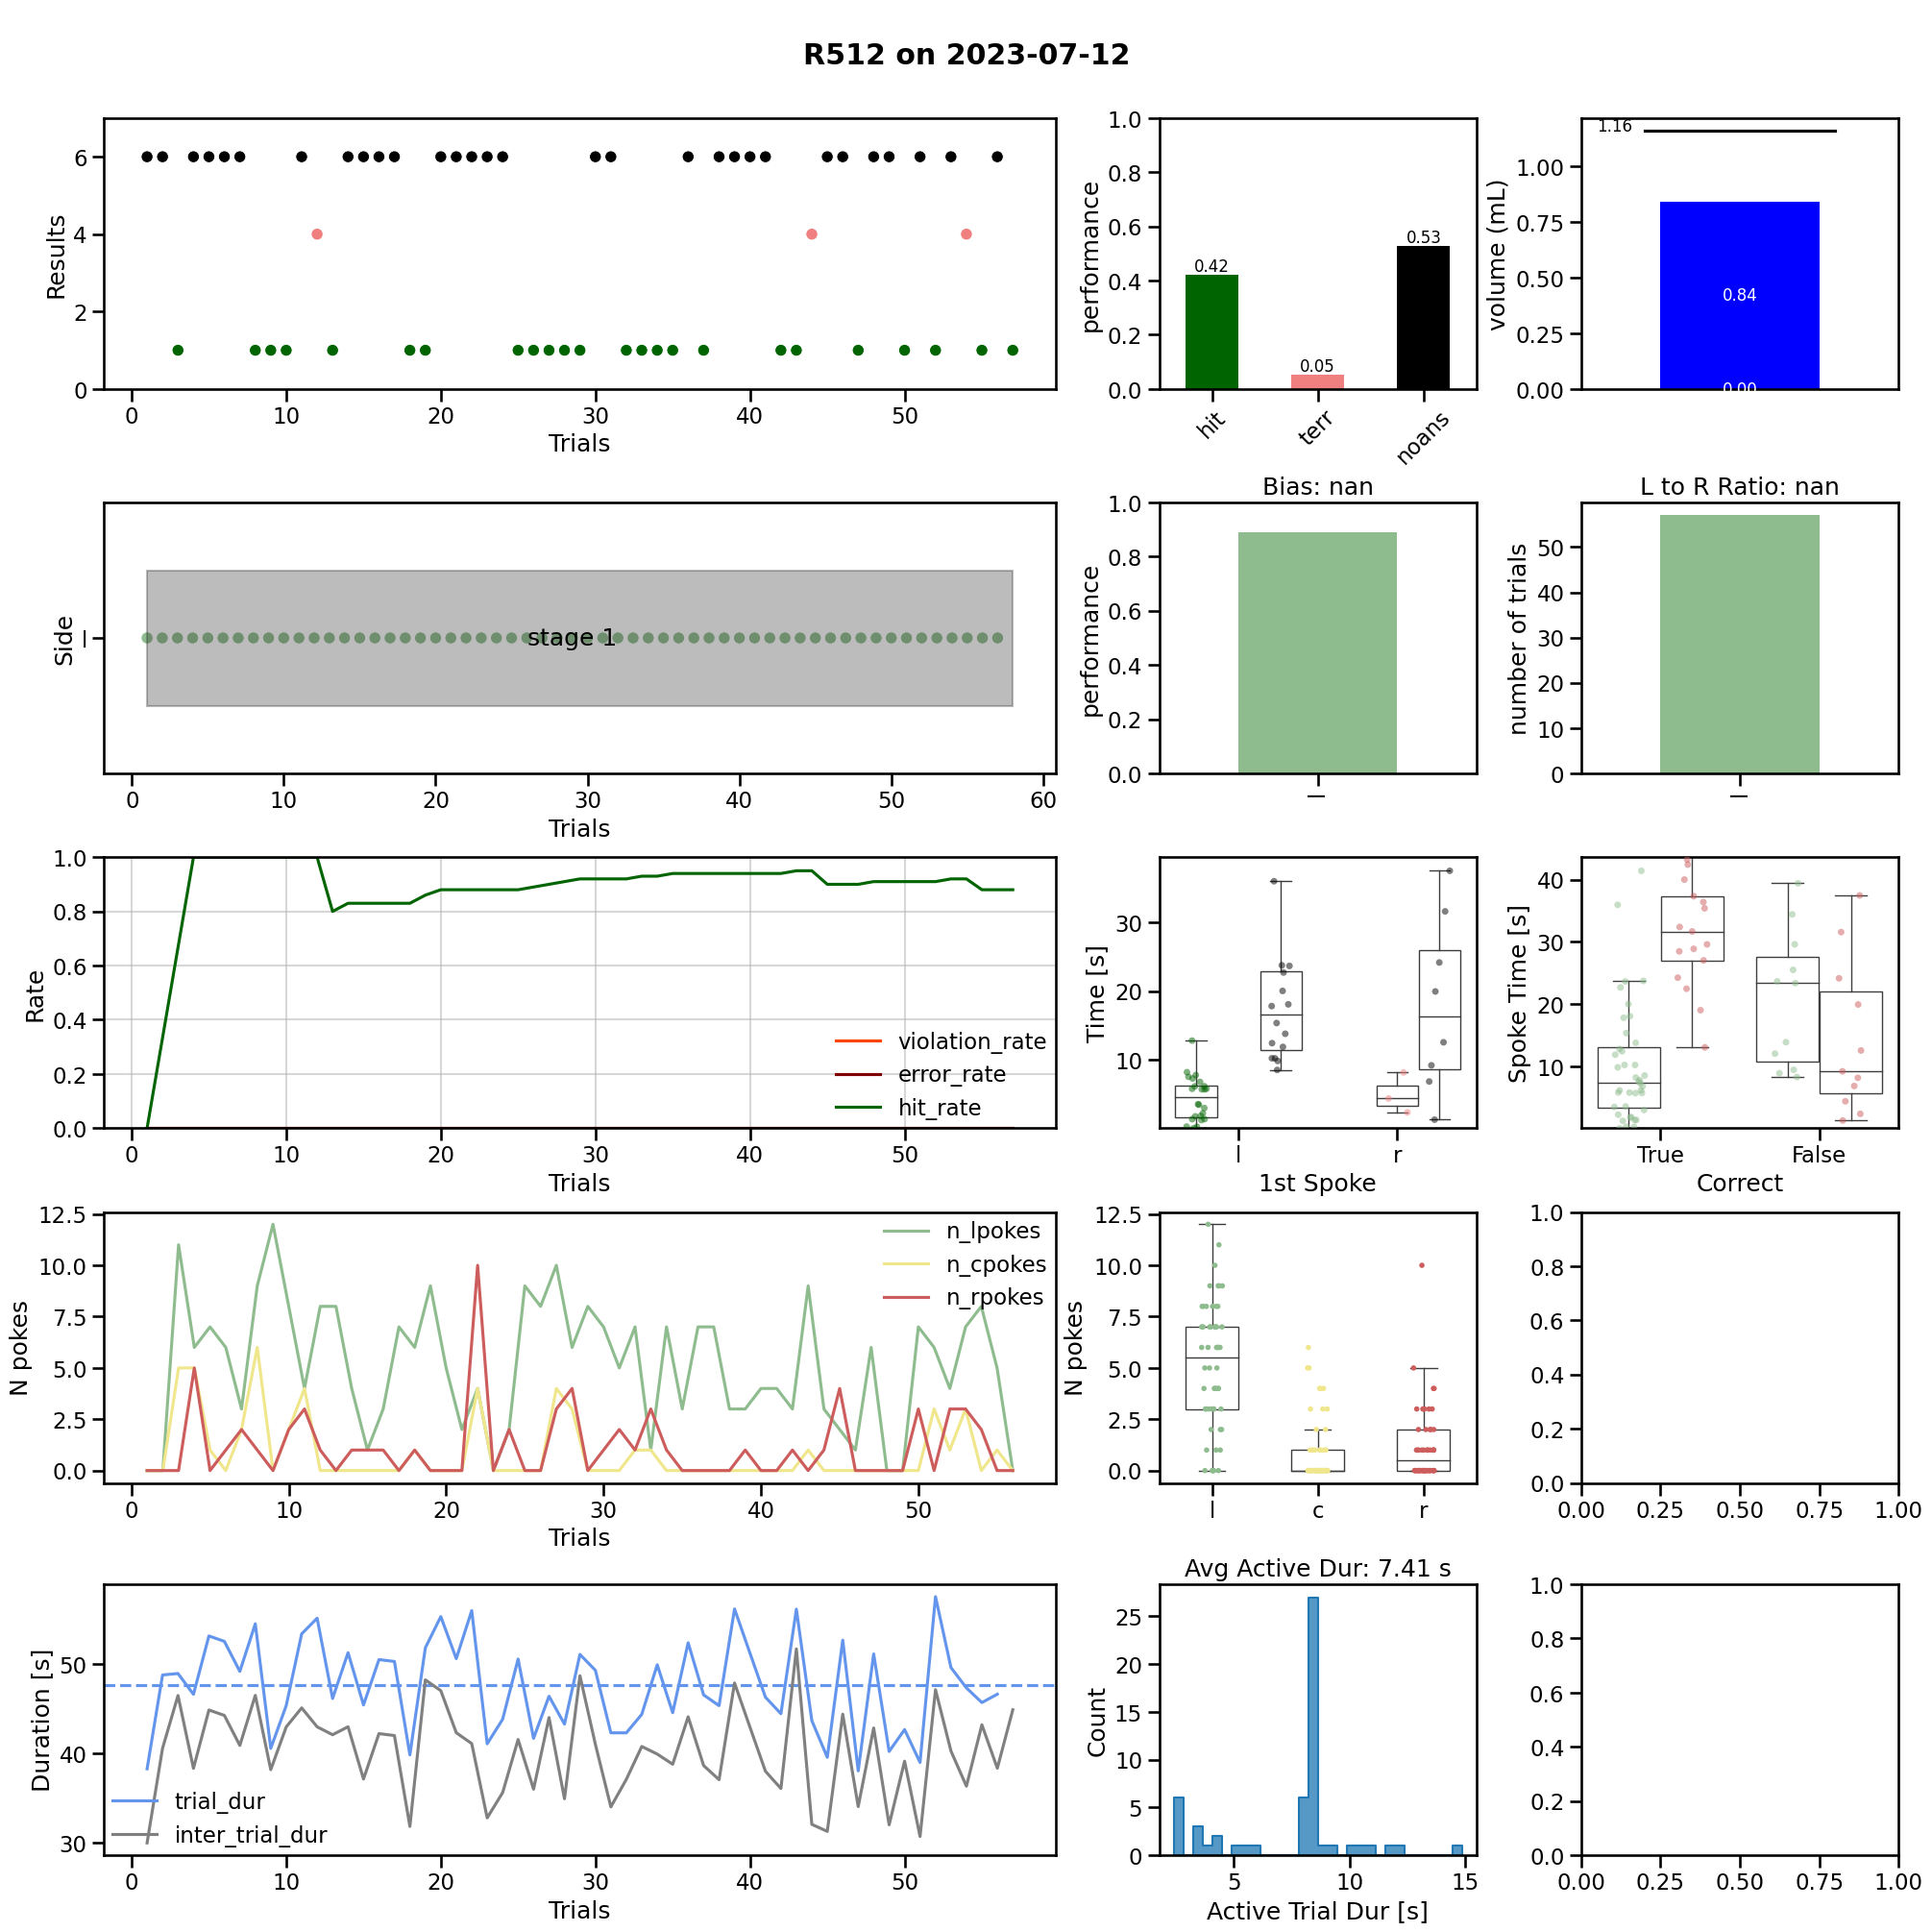

R513


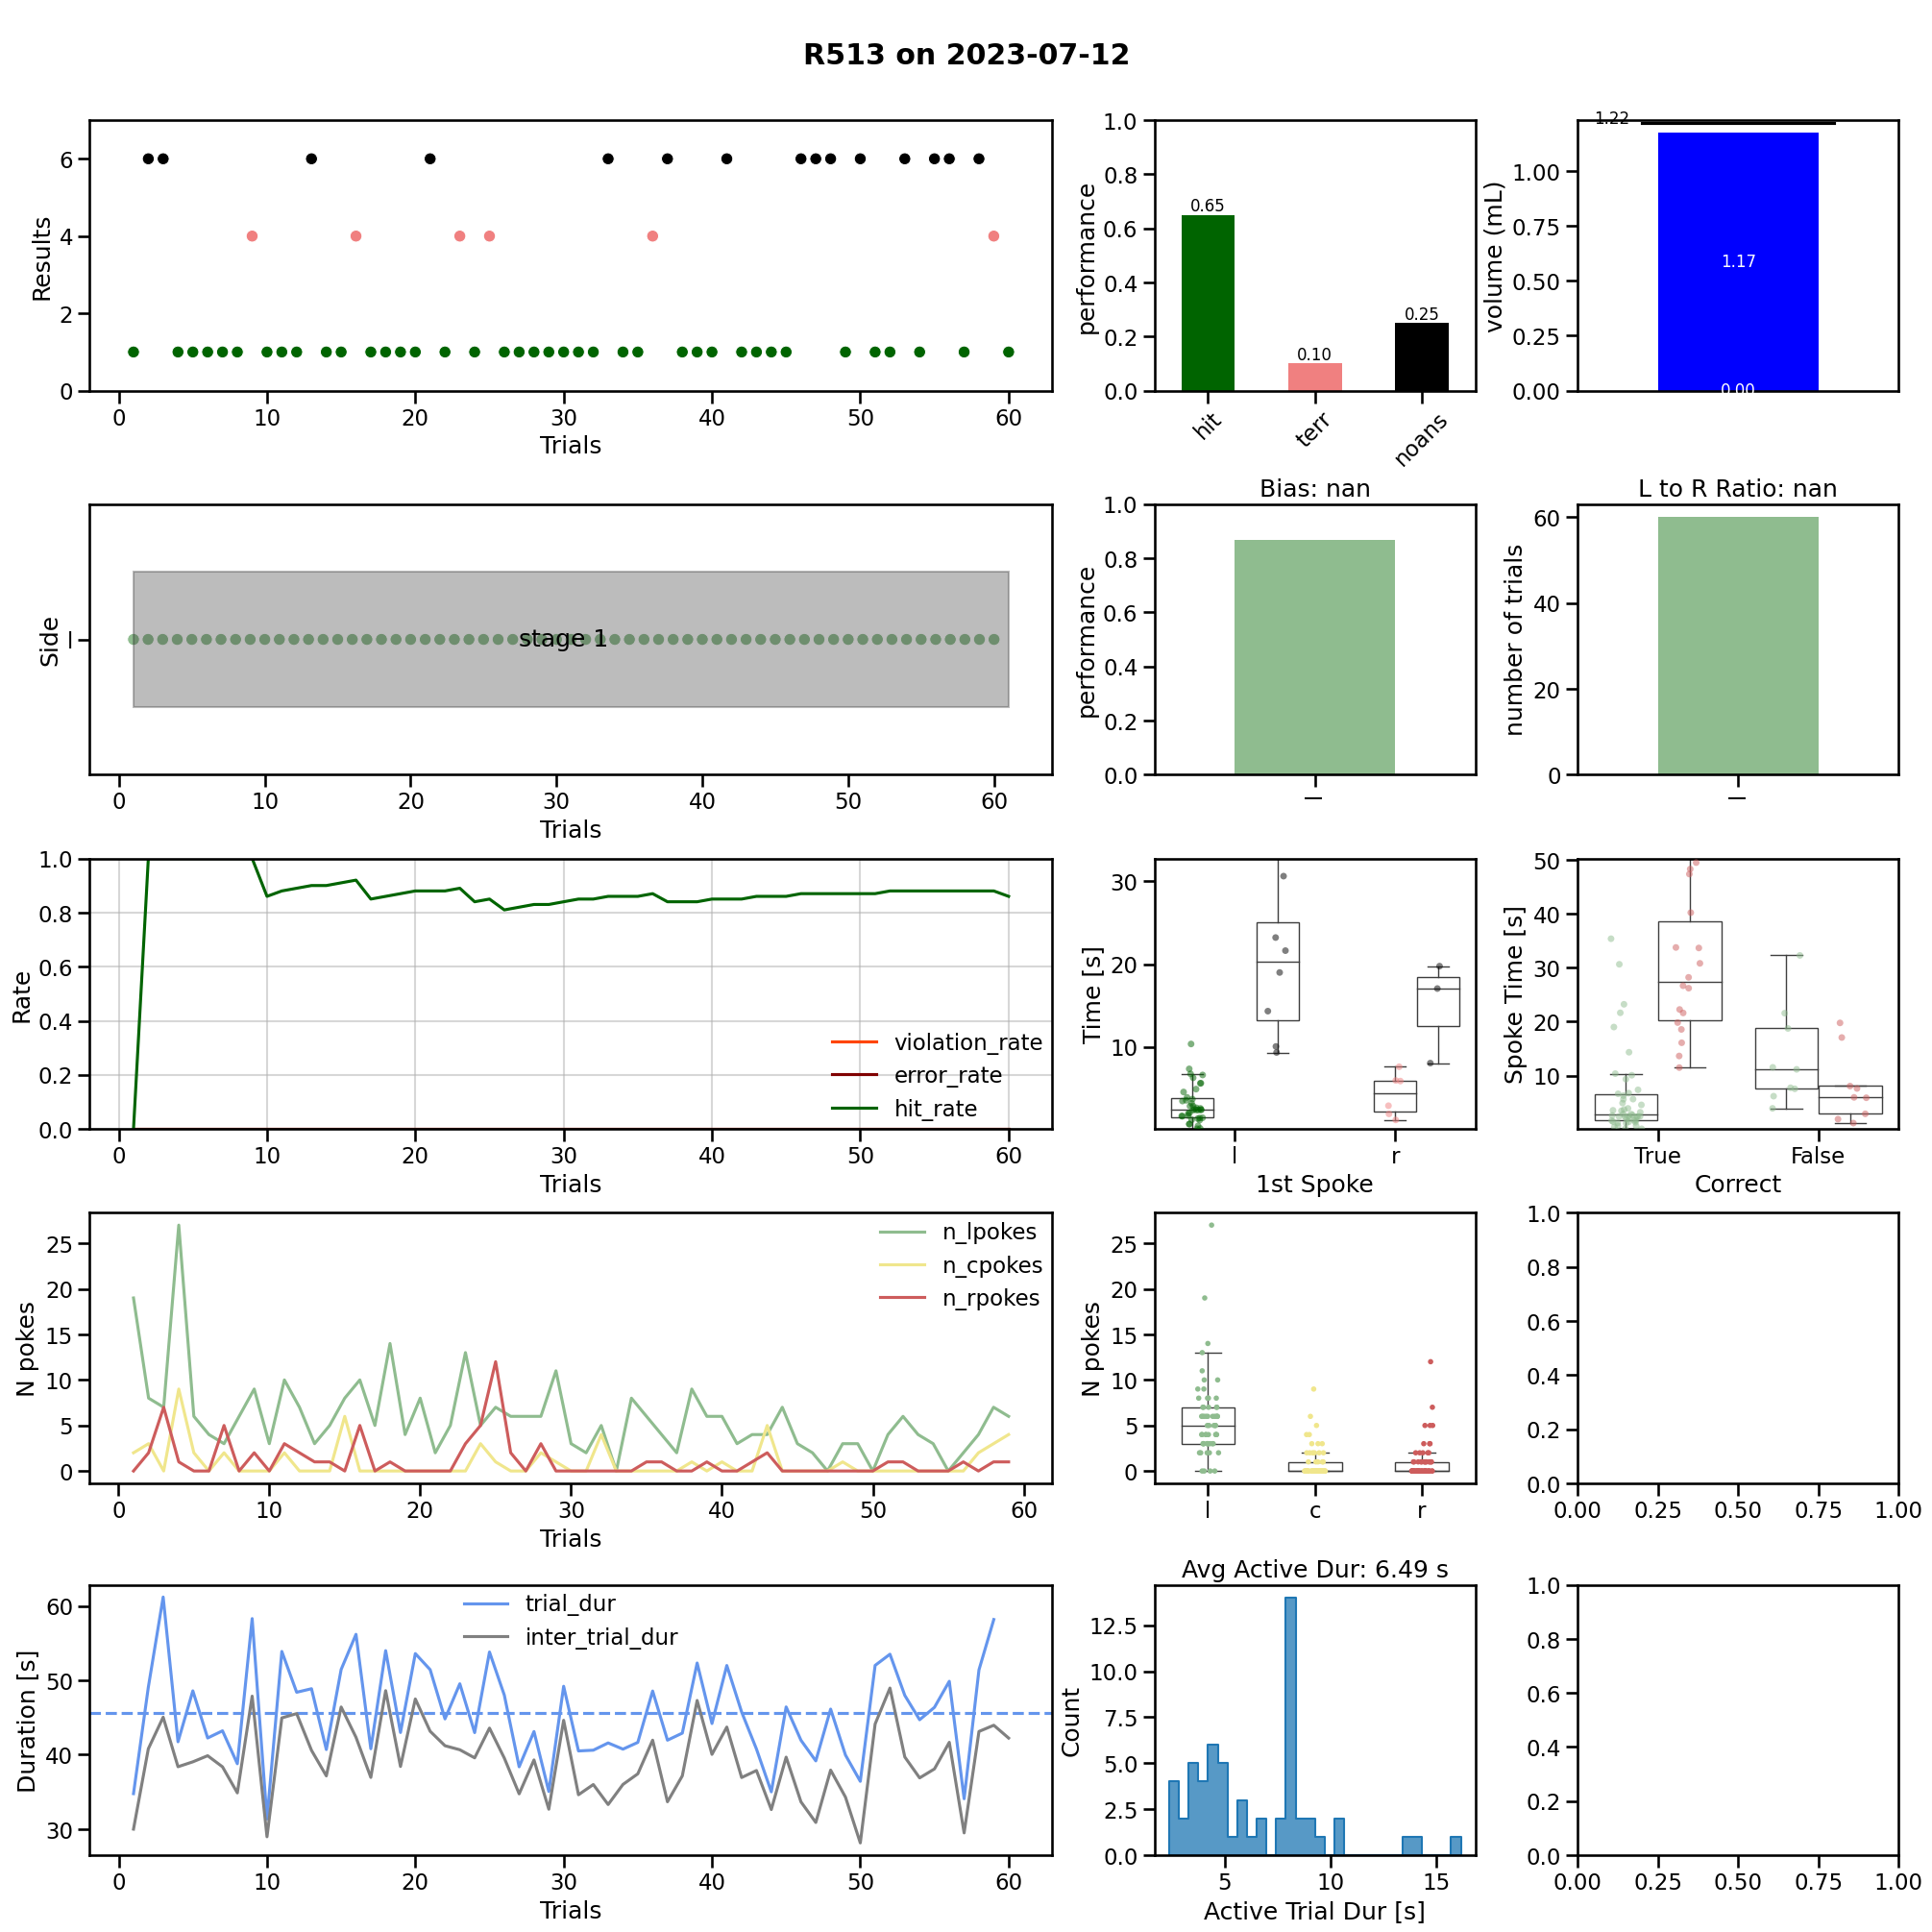

In [36]:
for (date, animal_id), sub_df in df.groupby(["date", "animal_id"]):
    multiplot_spoke_lg(sub_df, save_out=True, save_path=None)

### remaining plots
[x] l/r performance (copy over, switch putils)

[x] l/r count (copy over, switch putils)

[x] frac result (copy over, switch putils)

[x] n pokes over time

[x] swarm plot of npokes over time L/R/C

[x] time to spoke over time (copy over, switch putils)- pretty much just use this to get ready for the next plot

[x] swarm plot of time to spoke for L/R (add in mean, hue is 
hit/terror)

[x] iti/trial dur (add in hline w/ mean difference? or diff 
line)

[x] perf over trials (copy over, switch putils)
 
[x] water? 

[ ] (later) was block switch

[ ] (later) go sound give things

In [37]:
days_df = lazy_load_days_summary_df(
    date_min=date_min, date_max=datetime.today().strftime("%Y-%m-%d"), save_out=True
)

NameError: name 'date_min' is not defined

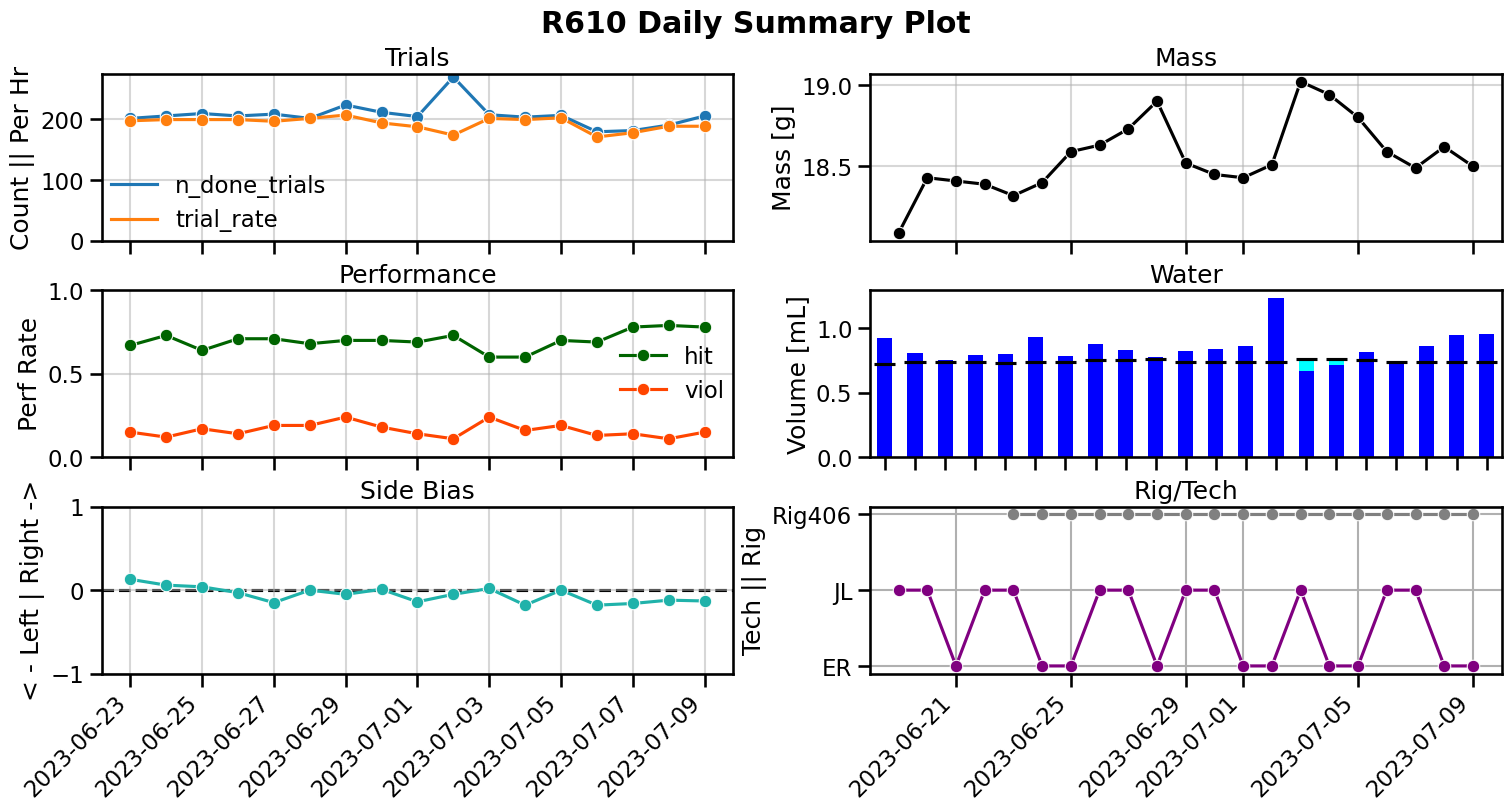

In [ ]:
plot_multiday_summary("R610", days_df)

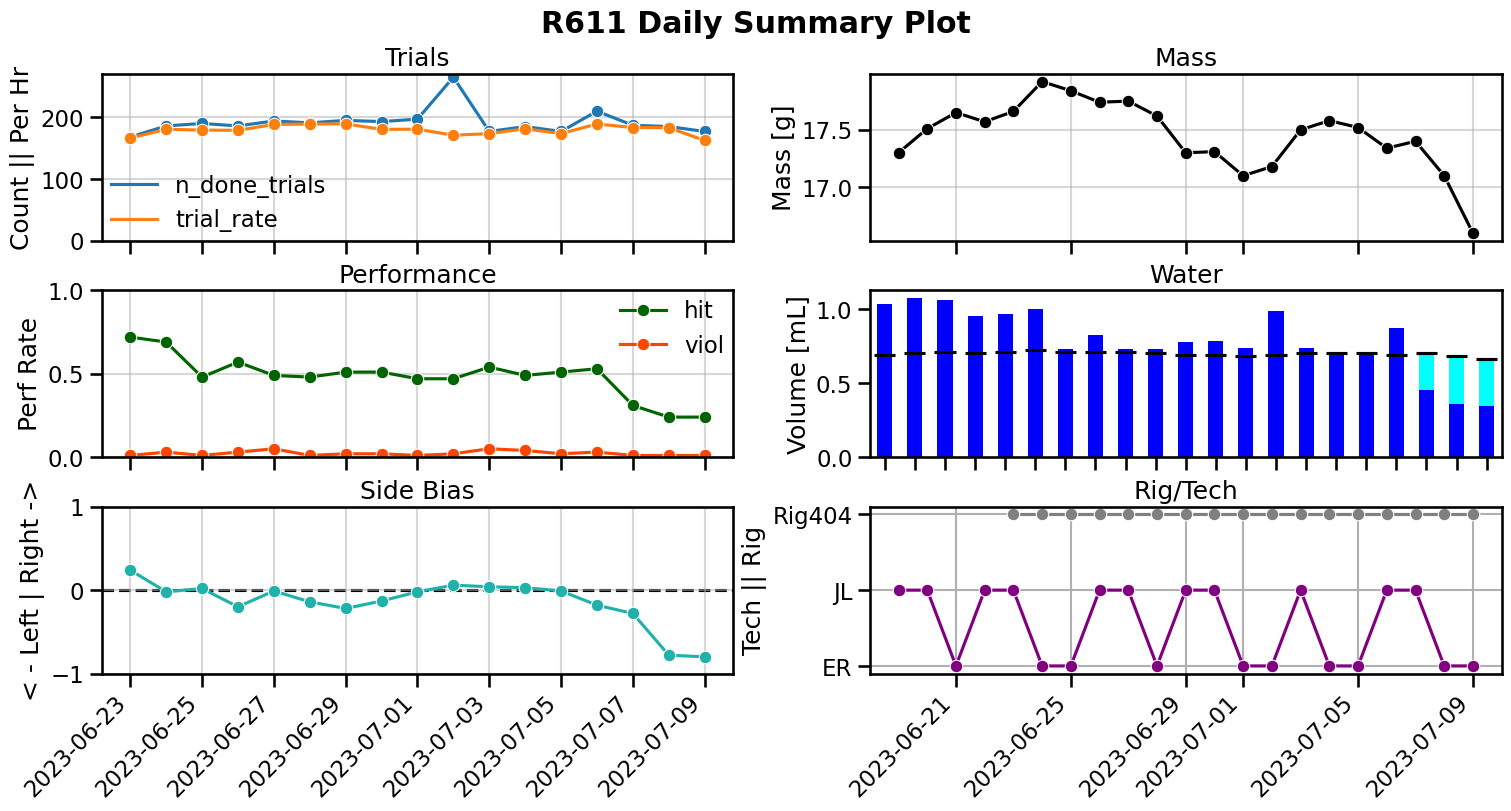

In [ ]:
plot_multiday_summary("R611", days_df)

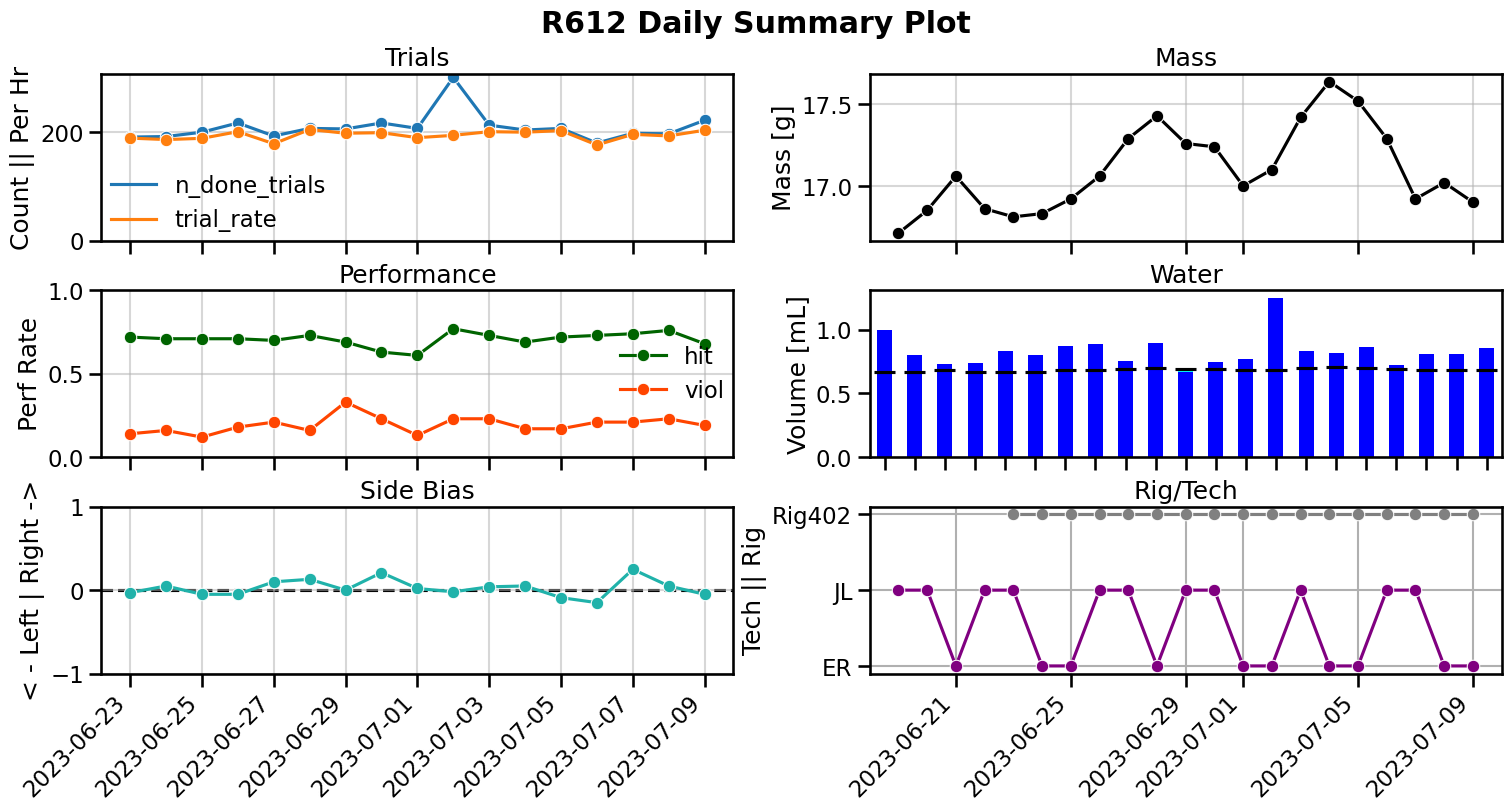

In [ ]:
plot_multiday_summary("R612", days_df)

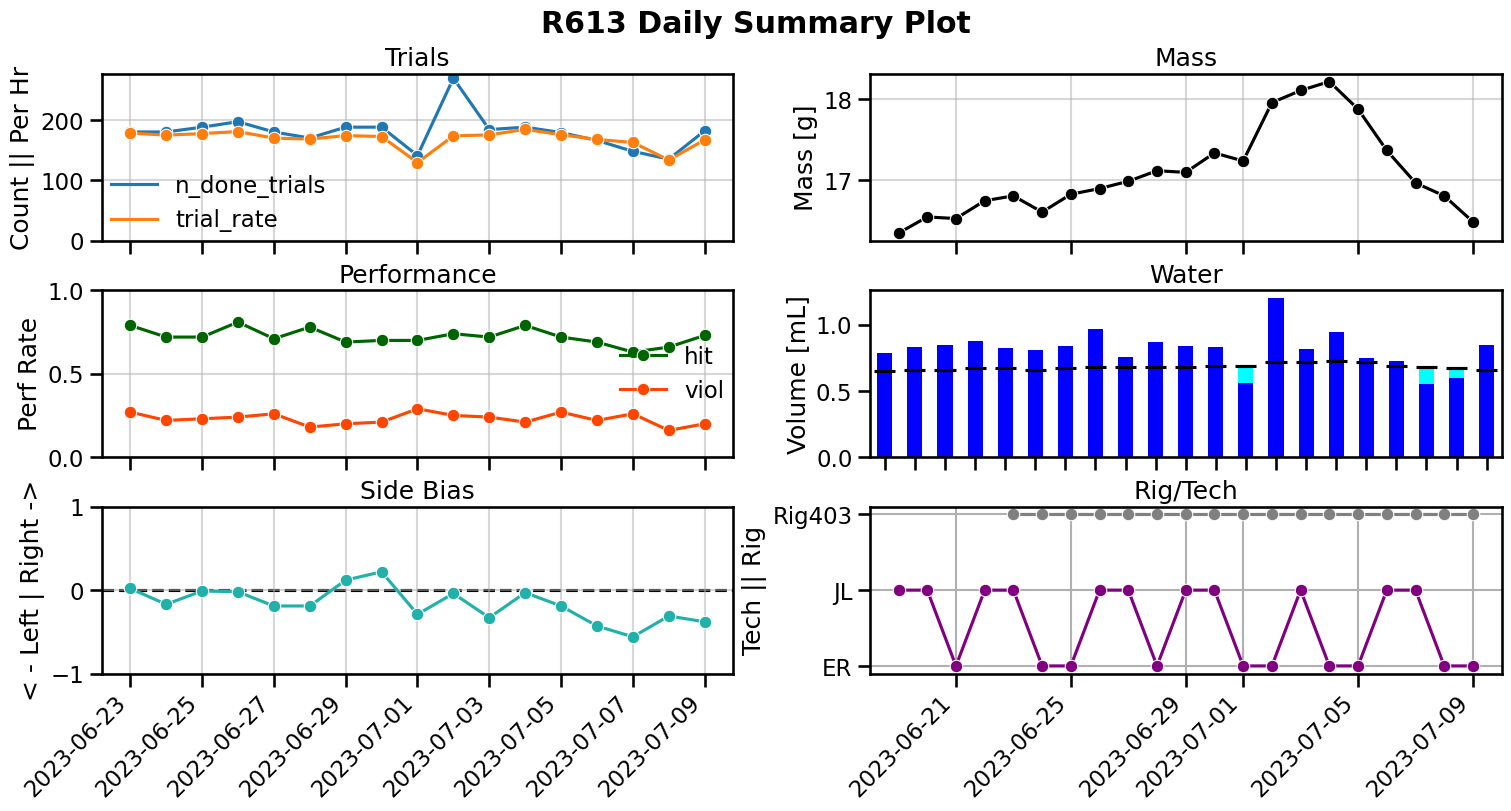

In [ ]:
plot_multiday_summary("R613", days_df)

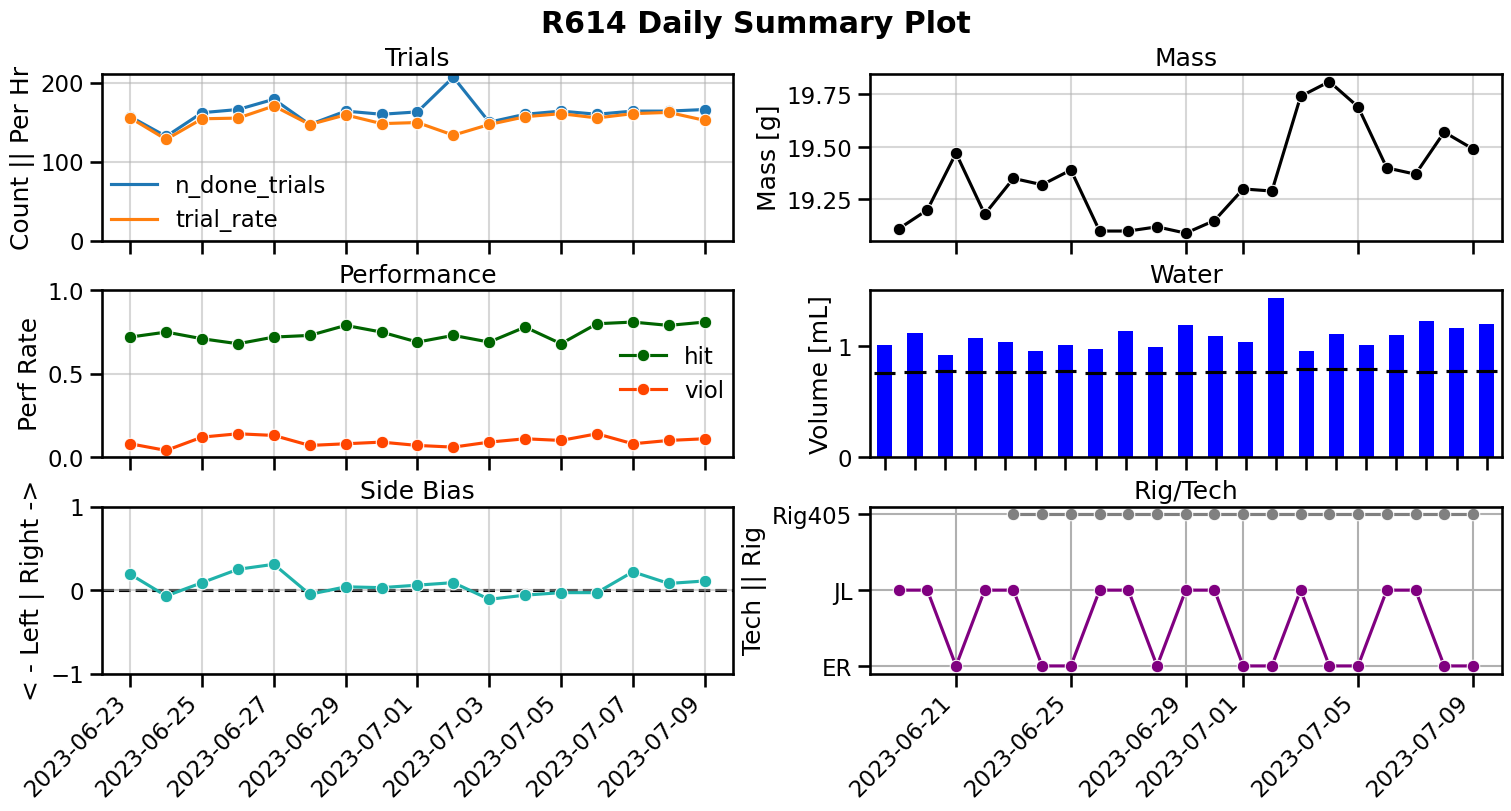

In [ ]:
plot_multiday_summary("R614", days_df)

## DEV

In [ ]:
# for animal_id, animal_df in days_df.groupby('animal_id'):
#     None
# from plot_days_info import *
# ## Initialize mutli-axis figure
# layout = """
#     AAABBB
#     CCCDDD
#     EEEFFF
# """
# fig = plt.figure(constrained_layout=True, figsize=(15,8))
# ax_dict = fig.subplot_mosaic(layout)  # ax to plot to
# plt.suptitle(f"\nR614 Daily Summary Plot", fontweight="semibold")


# ## Plot
# # left column
# plot_trials(animal_df, ax_dict["A"], title="Trials", legend=True, xaxis_label=False)
# plot_performance(animal_df, ax_dict["C"], title="Performance", xaxis_label=False)
# plot_side_bias(animal_df, ax_dict["E"], title="Side Bias", xaxis_label=True)

# # right column
# plot_mass(animal_df, ax_dict["B"], title="Mass", xaxis_label=False)
# plot_water_restriction(animal_df, ax_dict["D"], title="Water", legend=False, xaxis_label=False)
# plot_rig_tech(animal_df, ax_dict["F"], title="Rig/Tech", xaxis_label=True)

# # plots to add
# # stage plot X
# # time to spoke (or cpoke eventually) *
# # delay dur X
# # trial result plot (stacked or unstacked option, unstacked might be better) X
# # antibias params X
# ## eventually!
# # sessions start time
# # pre go/ viol off X
# # settling, pre go, sa, delay, sb, post sb times across days X
# add go cue dur if go is on?
# # give info, sma info, etc (maybe on oneof those dot plots)
# #
# # stimulus information